In [2]:
from load_data import load_pickle, dump_pickle
import fdt
import mhue
import homogeneity
import stability
import match_groundtruth
import region
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from tqdm.notebook import tqdm
import talib
import pandas as pd
import math
import os
import re
from scipy.stats import gaussian_kde
from scipy.ndimage import binary_fill_holes
def crop_image(image):
    x1 = np.min(np.where(image>1)[0])
    x2 = np.max(np.where(image>1)[0])
    y1 = np.min(np.where(image>1)[1])
    y2 = np.max(np.where(image>1)[1])
#     print((x1,x2),(y1,y2))
    return image[x1:x2, y1:y2]

In [3]:
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.dpi'] = 100

In [1]:
importlib.reload(mhue)

NameError: name 'importlib' is not defined

In [16]:
def run(input_idx=None):
    # Masking parameter
    beta = 10
    
    result = {}
    path = '../ixi-N4corrected/'
    filenames = os.listdir(path)
    img_org_lst = [cv.imread(path+filename,0) for filename in filenames]
    pattern = r'([0-9]+)-'
    img_idx = [re.findall(pattern,filename)[0] for filename in filenames]
    if input_idx != None:
        tmp = [img_idx.index(i) for i in input_idx]
        img_org_lst = [img_org_lst[i] for i in tmp]
        img_idx = [img_idx[i] for i in tmp]
    
    # Mask and crop the image
    img_lst = []
    scharr_lst = []
    for img in img_org_lst:
        _,mask = cv.threshold(img,beta,255,0)
        mask = binary_fill_holes(mask)
        img = img*mask
        img = crop_image(img)
        scharr = homogeneity.get_scharr(img)
        scharr = homogeneity.rank_normalize(scharr)
        scharr_lst.append(scharr)
        img_lst.append(img)
    
    
    # Calculate bdt
    print('======================================')
    print('Calculate BDT')
    print('======================================')
    img_bdts_o = []
    img_bdts_b = []
    for lst_idx,img in enumerate(img_lst):
        idx = img_idx[lst_idx]
        pickle_name_o = "../pickle/ixi/bdts_o"+str(idx)+".pkl"
        pickle_name_b = "../pickle/ixi/bdts_b"+str(idx)+".pkl"
        if os.path.exists(pickle_name_o):
            print('Index: {}, Pickle files found. BDT loaded from pickle.'.format(str(idx)))
            img_bdts_o.append(np.array(load_pickle(pickle_name_o)))
            img_bdts_b.append(np.array(load_pickle(pickle_name_b)))
        else:
            print('Index: {}, Calculating BDT...'.format(str(idx)))
            image = img_lst[lst_idx]
            inten_min = np.min(image)
            inten_max = np.max(image)
            n_pixels = np.size(image)
            t1 = inten_min + 2
            t2 = inten_max - 2
            bdts_o = []
            bdts_b = []
            for t in range(t1, t2):
                # object
                _, src = cv.threshold(image, t, 255, cv.THRESH_BINARY)
                transformer = fdt.FDT(src)
                bdt_o = transformer.cal_fdt(fdt=False,uint8=False)
                bdts_o.append(bdt_o)
                # background
                src = 255-src
                transformer = fdt.FDT(src)
                bdt_b = transformer.cal_fdt(fdt=False,uint8=False)
                bdts_b.append(bdt_b)
            # cache the bdt
            dump_pickle(pickle_name_o,bdts_o)
            dump_pickle(pickle_name_b,bdts_b)
            print('Index: {}, done. Pickle files saved.'.format(str(idx)))
            img_bdts_o.append(np.array(bdts_o))
            img_bdts_b.append(np.array(bdts_b))
    
    # original MHUE method
    print('======================================')
    print('Original MHUE method')
    print('======================================')
    uncertainty_lst = []
    mhue_lst = []
    mhue_t = []
    for idx,img in enumerate(img_lst):
        pickle_name = "../pickle/ixi/uncertainty"+str(img_idx[idx])+".pkl"
        if os.path.exists(pickle_name):
            uncertainty = load_pickle(pickle_name)
            print('Index: {}, pickle files found. Uncertainty loaded.'.format(str(img_idx[idx])))
        else:
            uncertainty = mhue.get_uncertainty(img)
            # cache Uncertainty
            dump_pickle(pickle_name,uncertainty)
            print('Index: {}, done. Pickle file saved.'.format(img_idx[idx]))
        uncertainty_lst.append(uncertainty)
        
        # homogeneity
        scharr = scharr_lst[idx]
        mhue_img = mhue.get_HU(uncertainty=uncertainty, homogeneity=scharr)
        mhue_lst.append(mhue_img)
        mhue_img = list(map(lambda x:np.sum(x), mhue_img))
        mhue_mint = np.argmin(mhue_img) + np.min(img) + 2
        print('Index: {}, MHUE threshold at: {}.'.format(img_idx[idx], mhue_mint))
        mhue_t.append(mhue_mint)
        
    # Stability
    print('======================================')
    print('Calculate EMA-stability metric')
    print('======================================')
    stab_lst = []
    stabema_lst = []
    for idx,img in enumerate(img_lst):
        bdt_o = img_bdts_o[idx]
        pickle_name = "../pickle/ixi/stab"+str(img_idx[idx])+".pkl"
        if os.path.exists(pickle_name):
            stab = load_pickle(pickle_name)
            print('Index: {}, pickle files found. Stability metric loaded.'.format(str(img_idx[idx])))
        else:
            stab = stability.get_stability(img,bdt_o,width=5,r_max=3,neighbours_min=6)
            # cache the stab metric
            dump_pickle(pickle_name,stab)
            print('Index: {}, done. Pickle file saved.'.format(img_idx[idx]))
        stab_lst.append(stab)
        stab = stability.pix_scale(stab,bdt_o)
        stab = stability.get_emastab(stab,10)
        stabema_lst.append(stab)
        
    
    # Weighted uncertainty
    print('======================================')
    print('Calculate Weighted uncertainty')
    print('======================================')
    uncertaintyw_lst = []
    for idx,img in enumerate(img_lst):
        pickle_name = "../pickle/ixi/uncertaintyw"+str(img_idx[idx])+".pkl"
        if os.path.exists(pickle_name):
            uncertaintyw = load_pickle(pickle_name)
            uncertaintyw_lst.append(uncertaintyw)
            print('Index: {}, pickle files found. Weighted-uncertainty loaded.'.format(str(img_idx[idx])))
        else:
            bdt = list(map(lambda x,y: x+y, img_bdts_o[idx], img_bdts_b[idx]))
            uncertaintyw = mhue.get_uncertainty(img, off_center=True, info_w=True, stabs=stab_lst[idx], 
                                                bdts_o=img_bdts_o[idx], bdts_b=img_bdts_b[idx],kernel_size=21,sigma=0.3)
            # cache the Weighted uncertainty
            dump_pickle(pickle_name,uncertaintyw)
            uncertaintyw_lst.append(uncertaintyw)
            print('Index: {}, done. Pickle file saved.'.format(img_idx[idx]))
        uncertaintyw = list(map(lambda x:np.sum(x), uncertaintyw))
    
    # Weighted MHUE
    print('======================================')
    print('Calculate Weighted MHUE')
    print('======================================')
    mhuew_lst = []
    for idx,img in enumerate(img_lst):
        uncertaintyw = uncertaintyw_lst[idx]
        scharr = scharr_lst[idx]
        mhuew_i = mhue.get_HU(uncertainty=uncertaintyw, homogeneity=scharr)
        mhuew_lst.append(mhuew_i)
        print('Index: {}, done.'.format(img_idx[idx]))

    # New region methods
    print('======================================')
    print('Calculate Weighted Region score')
    print('======================================')
    regions = []
    for idx,img in enumerate(img_lst):
        pickle_name = "../pickle/ixi/region"+str(img_idx[idx])+".pkl"
        if os.path.exists(pickle_name):
            region_i = load_pickle(pickle_name)
            print('Index: {}, pickle files found. Region score loaded.'.format(str(img_idx[idx])))
        else:
            uncertaintyw = uncertaintyw_lst[idx]
            scharr = scharr_lst[idx]
            region_i = region.get_score(img,uncertainty=uncertaintyw,homogeneity=scharr,kernel_size=7)
            dump_pickle(pickle_name,region_i)
            print('Index: {}, done. Pickle file saved.'.format(img_idx[idx]))
        regions.append(region_i)
        best_region_t = np.argmax(list(map(lambda x:np.sum(x),region_i))) + np.min(img) + 2
        print('Index: {}, Region score threshold at: {}.'.format(img_idx[idx], best_region_t))
        dump_pickle(pickle_name,region_i)
        
    # return dict
    result['bdts_o'] = img_bdts_o
    result['bdts_b'] = img_bdts_b
    result['mhue'] = mhue_lst
    result['stab'] = stab_lst
    result['stabema'] = stabema_lst
    result['uncertaintyw'] = uncertaintyw_lst
    result['uncertainty'] = uncertainty_lst
    result['mhuew'] = mhuew_lst
    result['img'] = img_lst
    result['regions'] = regions
    
    return result

In [17]:
idx_lst = ['109','045','012','113','041','059','084','089','105','035']
# idx = ['109','045','012','113','041','059','084']
res = run(idx_lst)

Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Get Scharr gradient value, done.
Calculate BDT
Index: 109, Pickle files found. BDT loaded from pickle.
Index: 045, Pickle files found. BDT loaded from pickle.
Index: 012, Pickle files found. BDT loaded from pickle.
Index: 113, Pickle files found. BDT loaded from pickle.
Index: 041, Pickle files found. BDT loaded from pickle.
Index: 059, Pickle files found. BDT loaded from pickle.
Index: 084, Pickle files found. BDT loaded from pickle.
Index: 089, Pickle files found. BDT loaded from pickle.
Index: 105, Pickle files found. BDT loaded from pickle.
Index: 035, Pickle files found. BDT loaded from pickle.
Original MHUE method
Index: 109, pickle files found. Uncertainty loaded.
Index: 109, MHUE thresh

In [18]:
_uncertainty = res['uncertainty']
_img = res['img']
_stab = res['stab']
_mhue = res['mhue']
_mhuew = res['mhuew']
_uncertaintyw = res['uncertaintyw']
_region = res['regions']

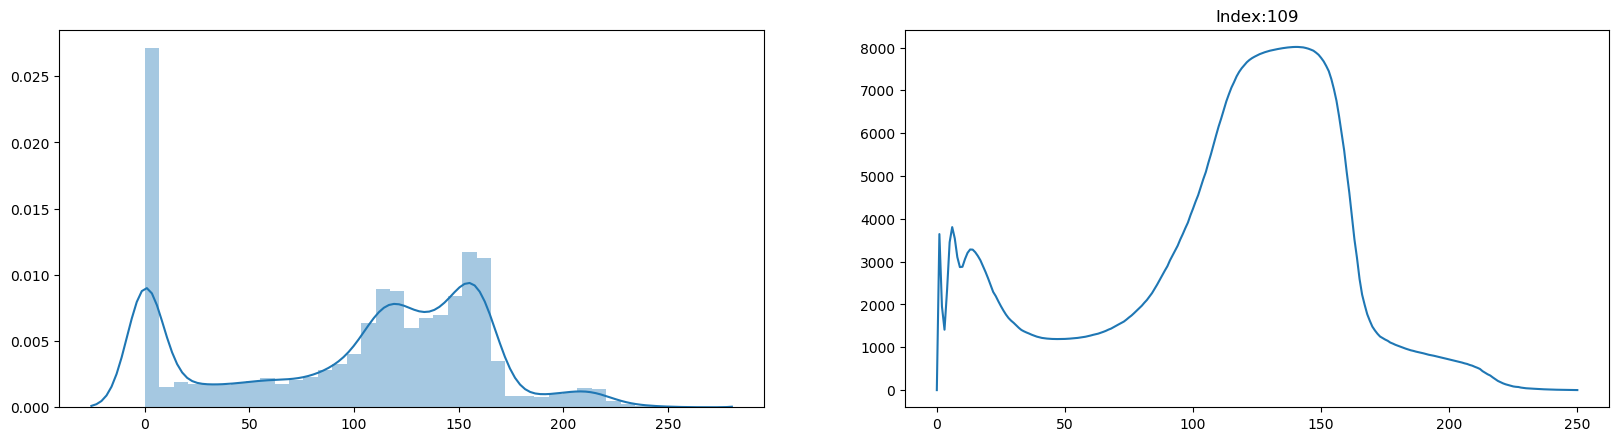

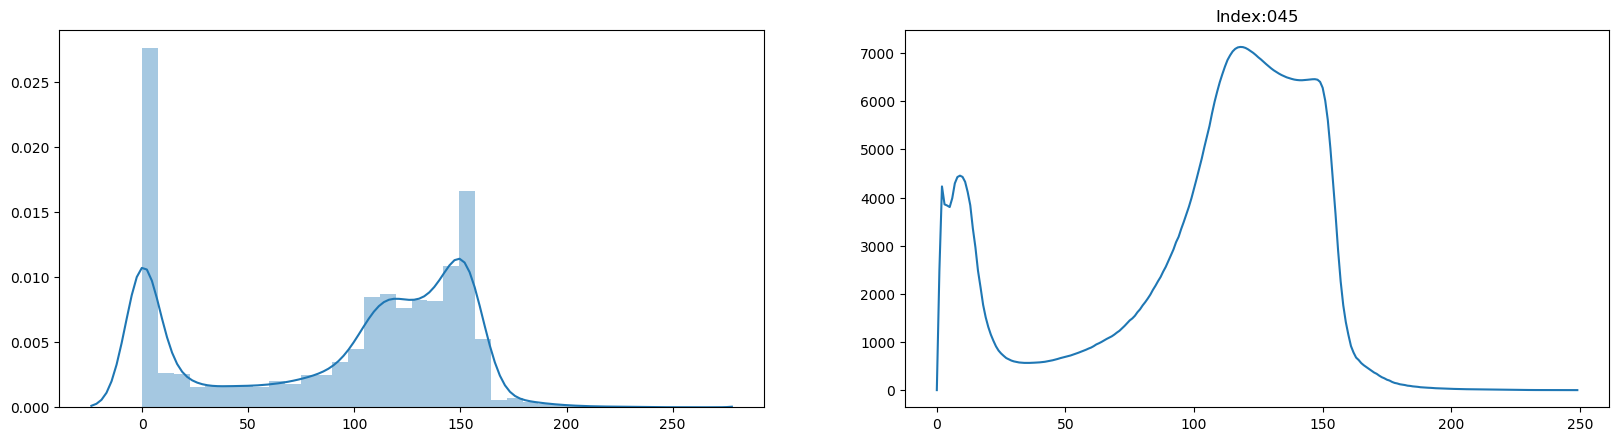

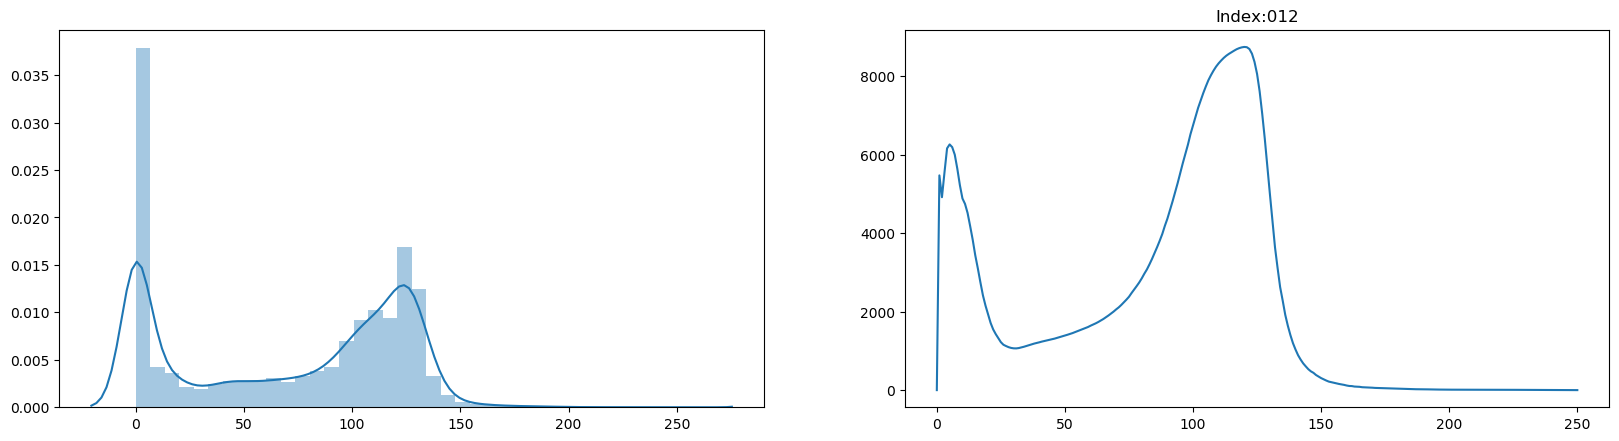

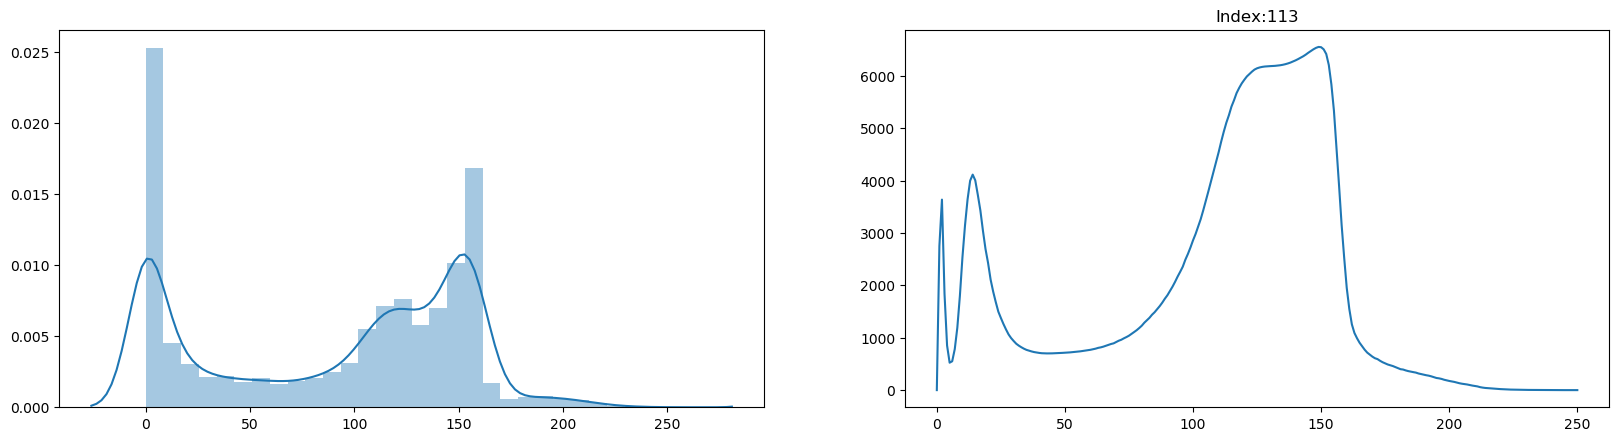

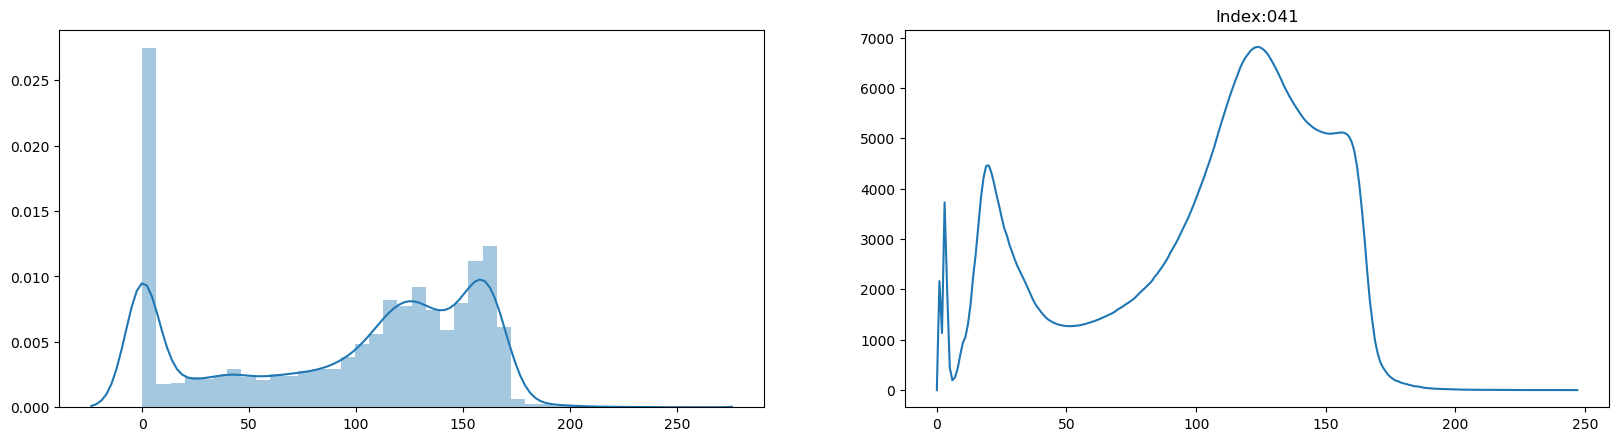

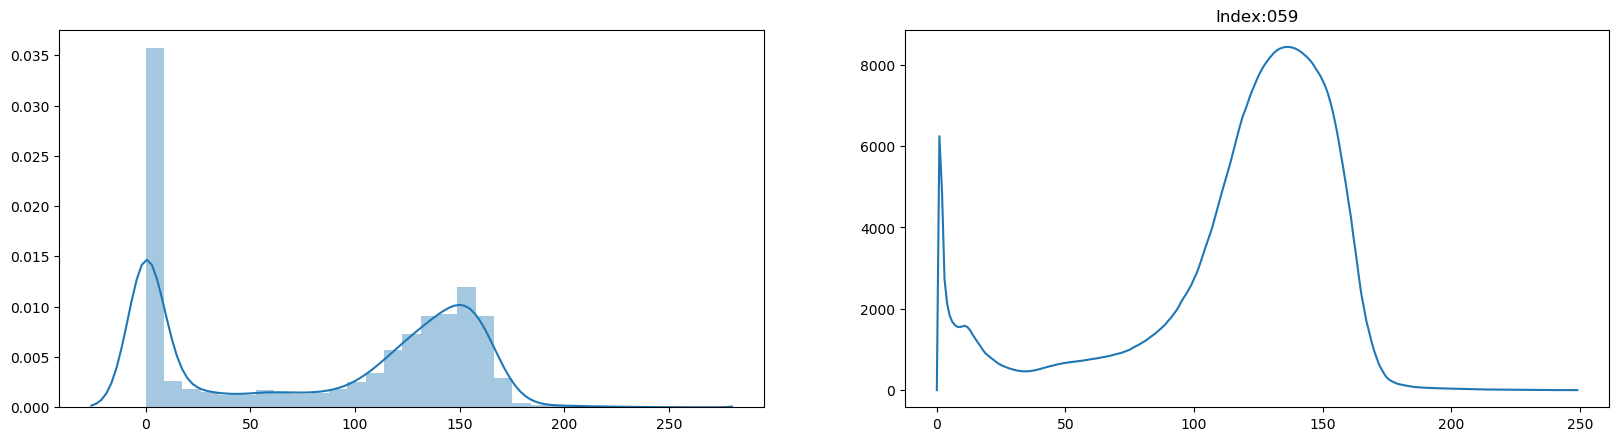

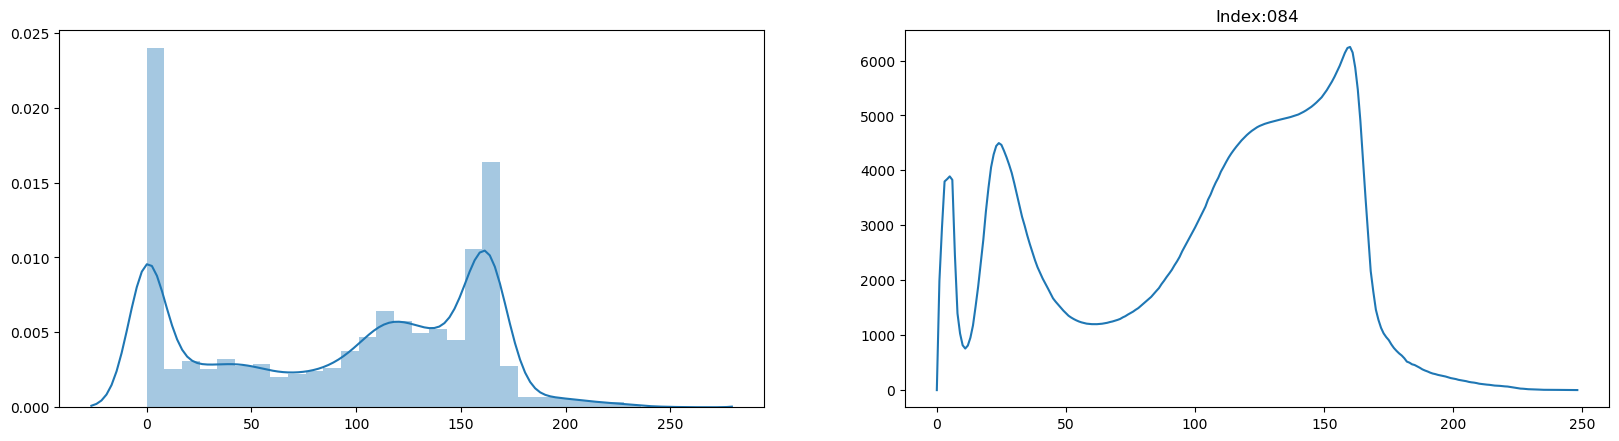

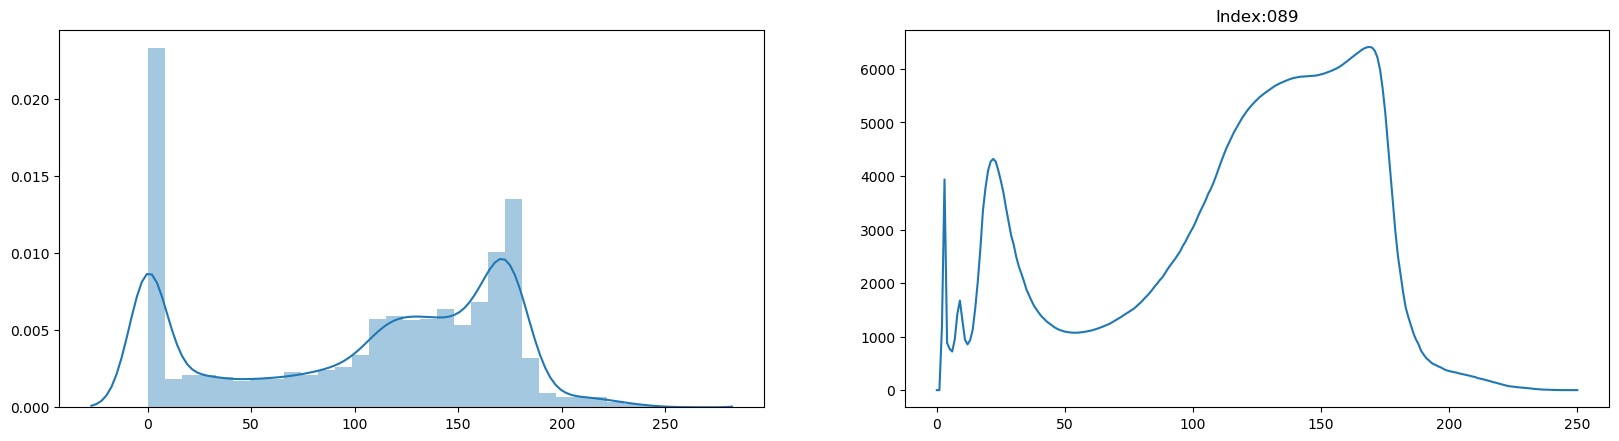

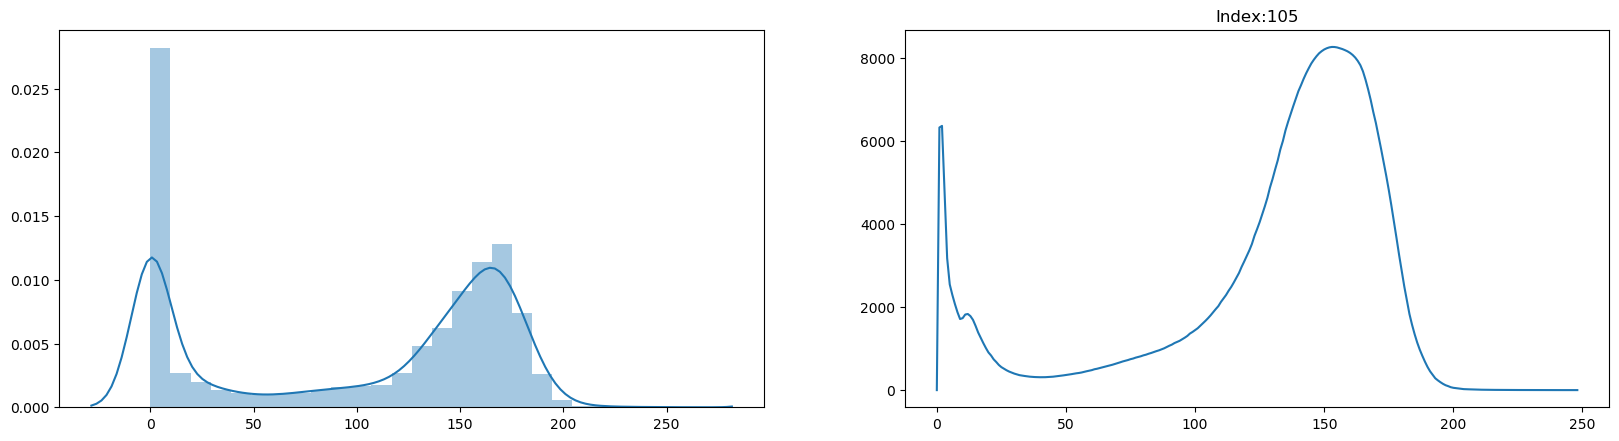

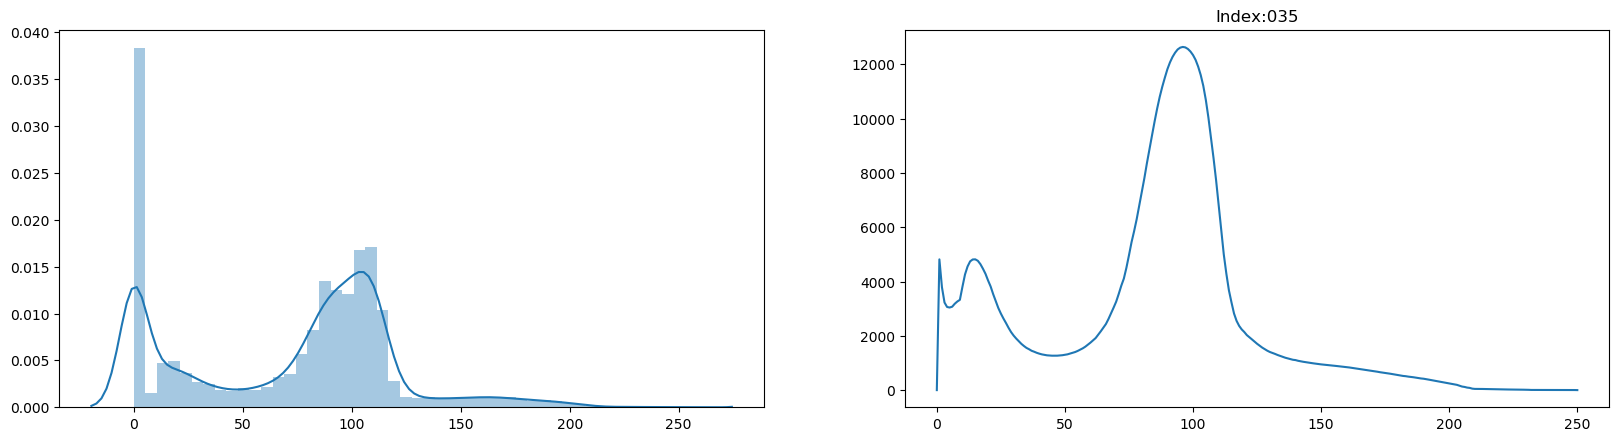

In [20]:
for i in range(len(_img)):
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    sns.distplot(_img[i])
    plt.subplot(122)
    plt.plot(list(map(lambda x:np.sum(x),_uncertainty[i])))
    plt.title('Index:{}'.format(str(idx_lst[i])))

In [24]:
# for i in range(len(_img)):
#     plt.figure(figsize=(20,5))
#     plt.subplot(121)
#     sns.distplot(_img[i])
#     plt.subplot(122)
#     plt.plot(list(map(lambda x:np.sum(x),_uncertainty[i])))

187184.78958820205 101443120.78674118 0.008477517447444027
21323343.87637975 101443120.78674118 0.9657249402985234
560589.3171591465 101443120.78674118 0.025388845576194908
6064.323219247132 101443120.78674118 0.0002746505525967576
2959.7574884264204 101443120.78674118 0.00013404612524093443


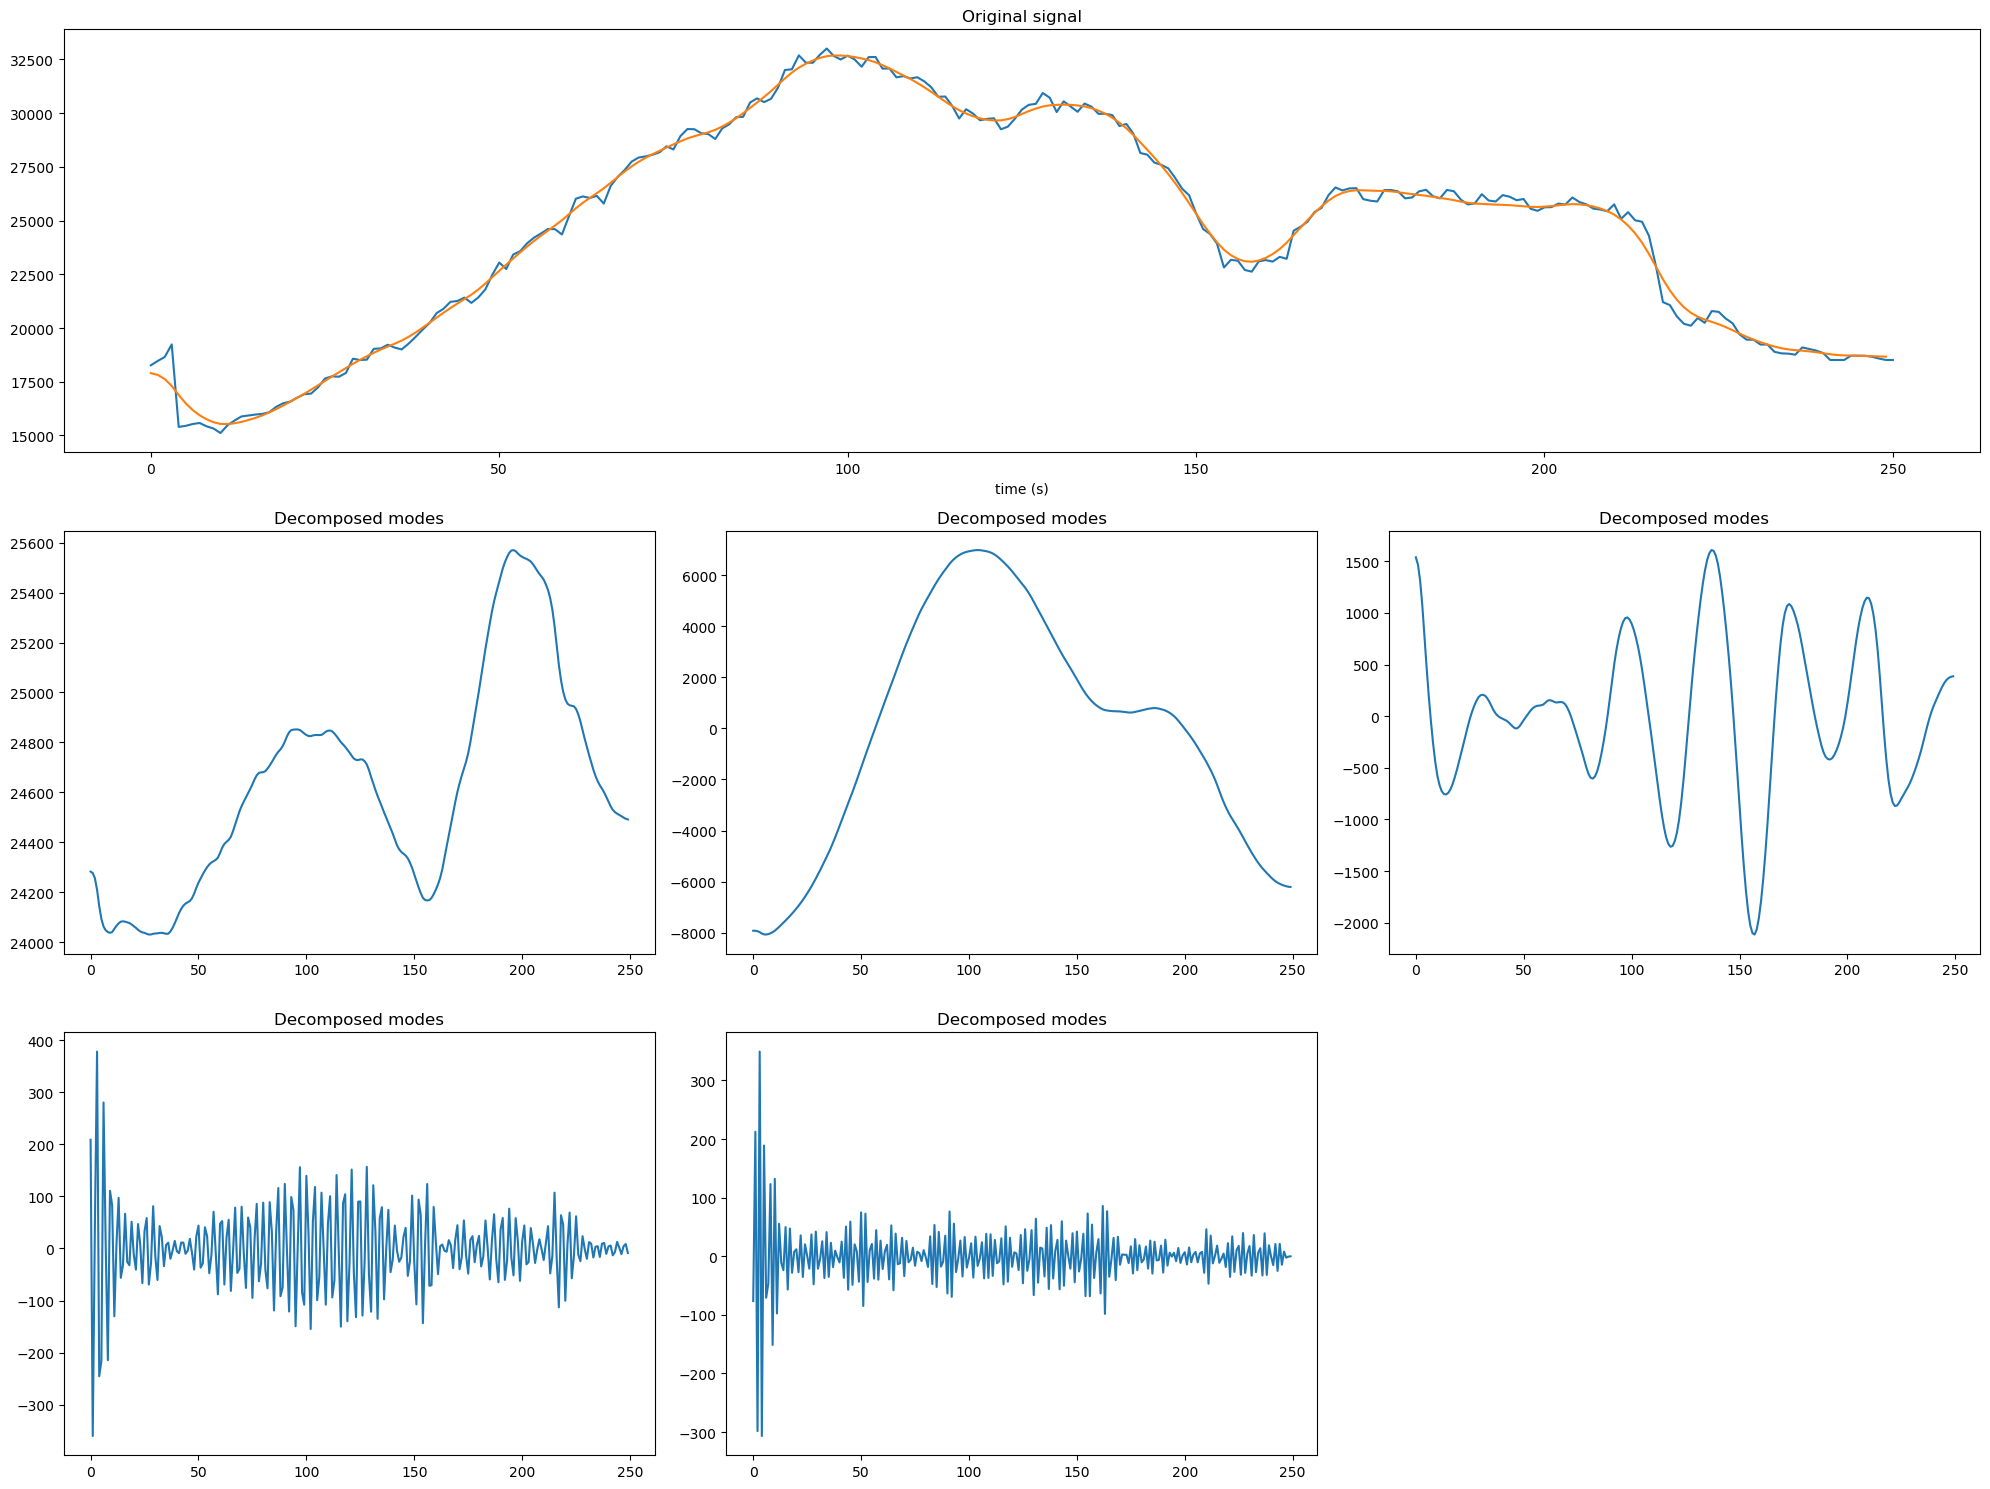

In [34]:
_r = list(map(lambda x:np.sum(x),_region[0]))
y, _r_recon_hat, omega = VMD(_r, alpha=2000, tau=0.0, K=5, DC=0, init=1, tol=1e-7)
# _r_recon = _r_recon[0,:] + _r_recon[1,:]
# ax3.plot(_r_recon,color='navy',label='Reconstructed RS')
plt.figure(figsize=(20,15))
plt.subplot(311)
plt.plot(_r)
plt.plot(y[0,:]+y[1,:]+y[2,:])
plt.title('Original signal')
plt.xlabel('time (s)')
plt.subplot(334)
plt.plot(y[0,:].T)
plt.title('Decomposed modes')
plt.subplot(335)
plt.plot(y[1,:].T)
plt.title('Decomposed modes')
plt.subplot(336)
plt.plot(y[2,:].T)
plt.title('Decomposed modes')
plt.subplot(337)
plt.plot(y[3,:].T)
plt.title('Decomposed modes')
plt.subplot(338)
plt.plot(y[4,:].T)
plt.title('Decomposed modes')

# plt.legend(['Mode %d'%m_i for m_i in range(y.shape[0])])
plt.tight_layout()

for mode in range(y.shape[0]):
    rate = np.var(y[mode,:])/np.sum(np.var(y,axis=1))
    print(np.var(y[mode,:]),np.var(y),rate)

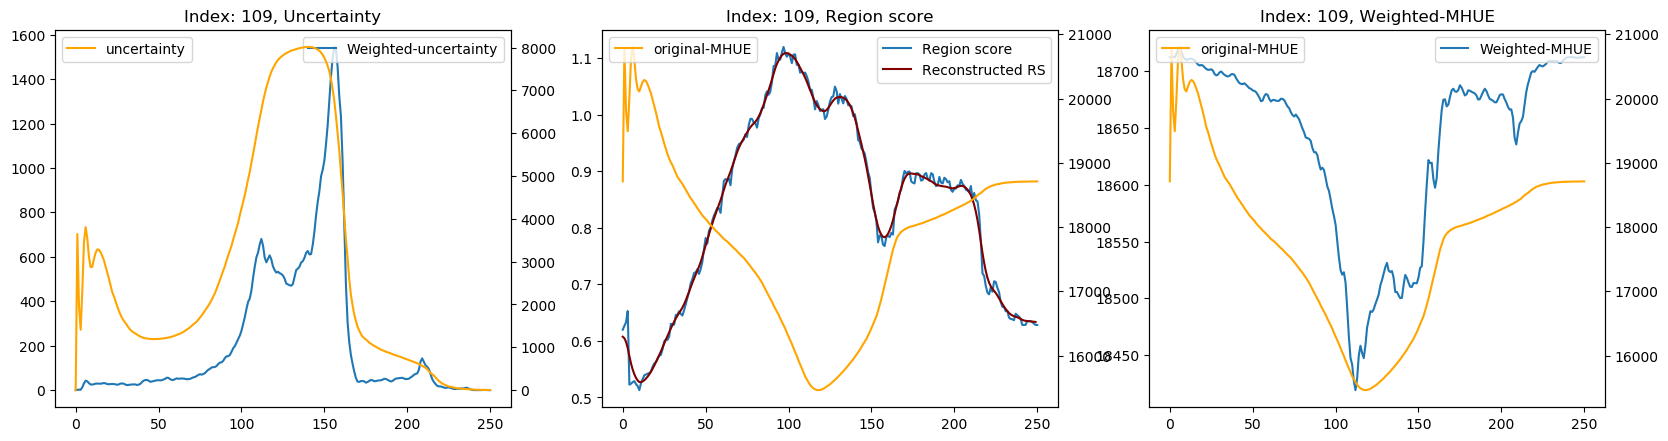

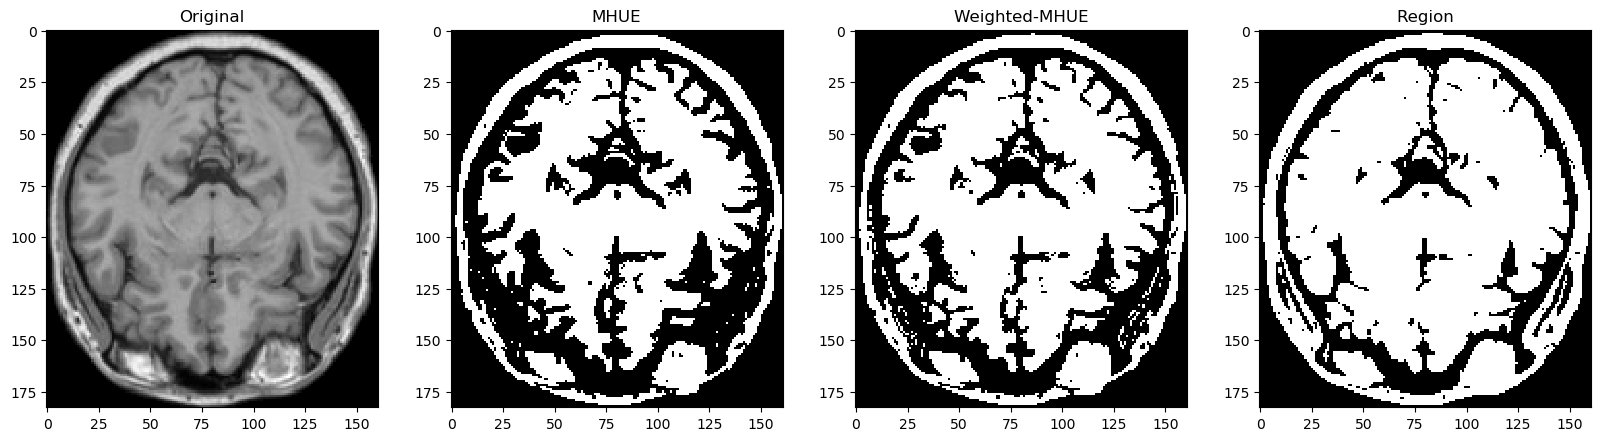

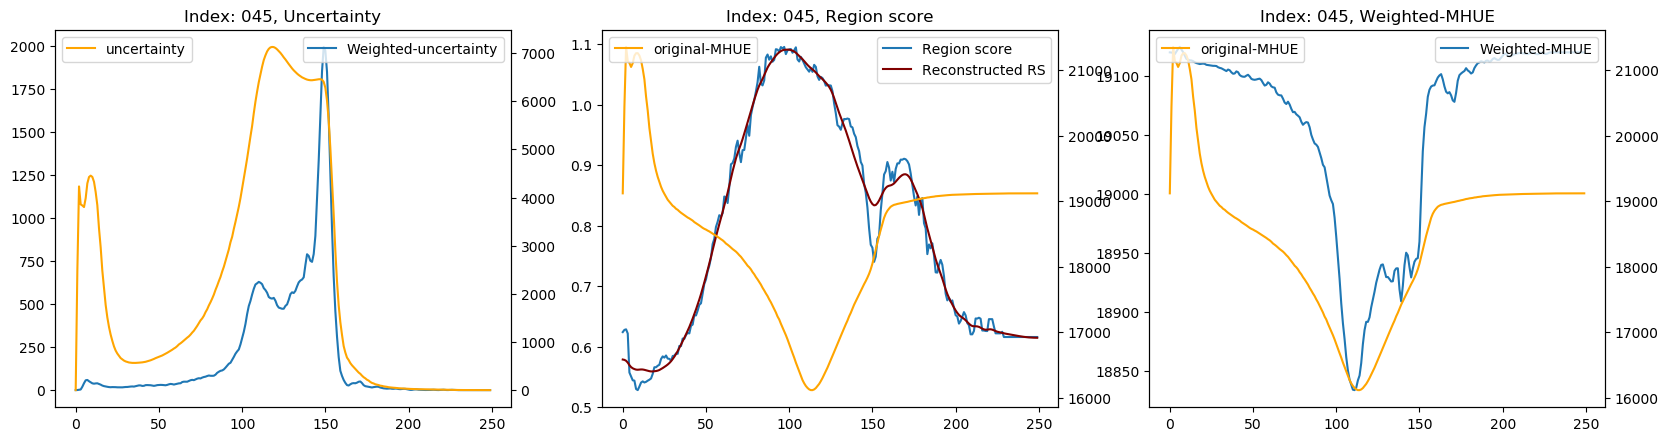

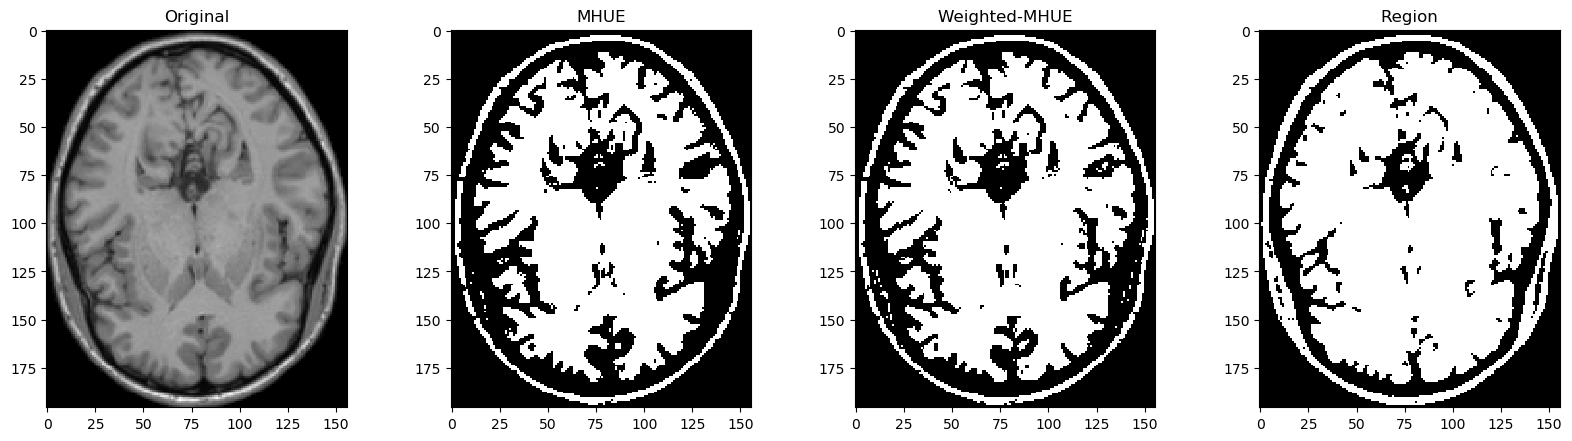

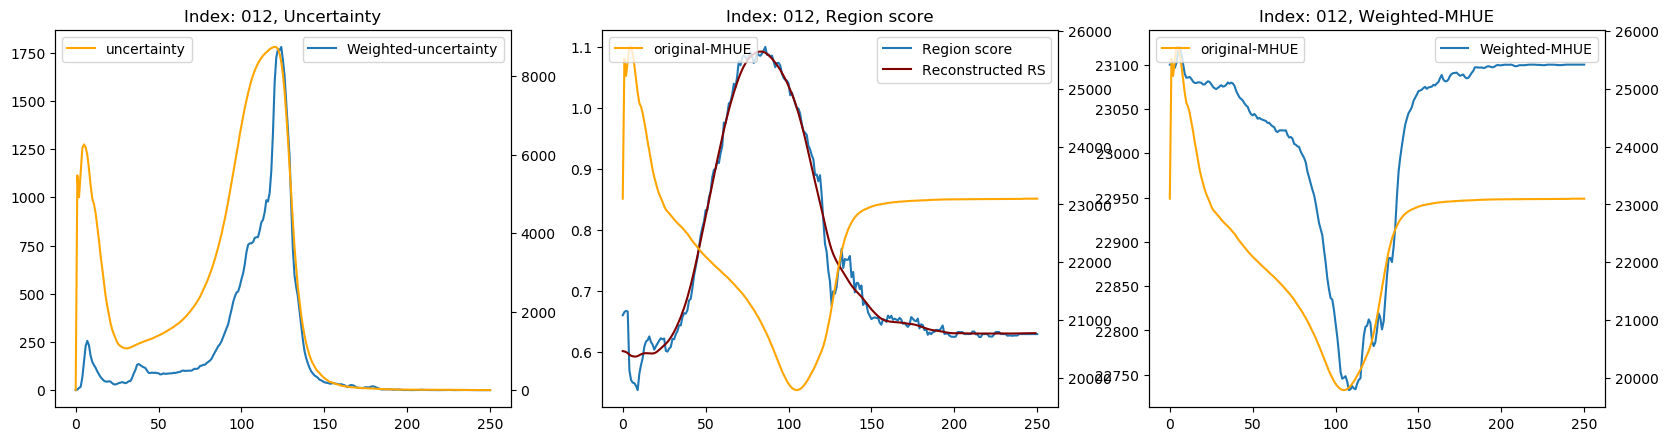

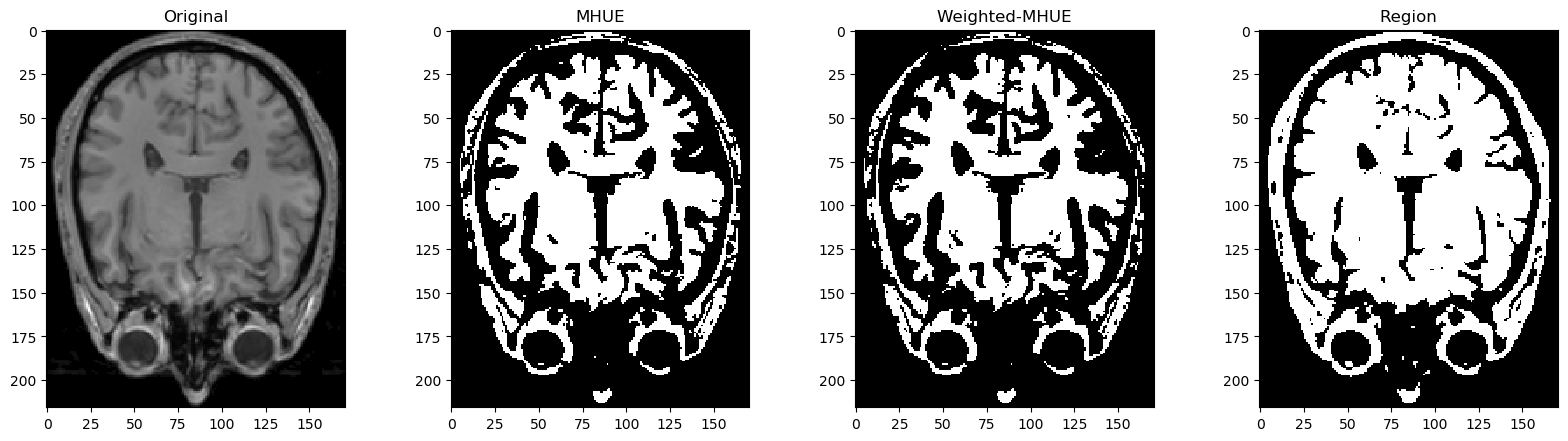

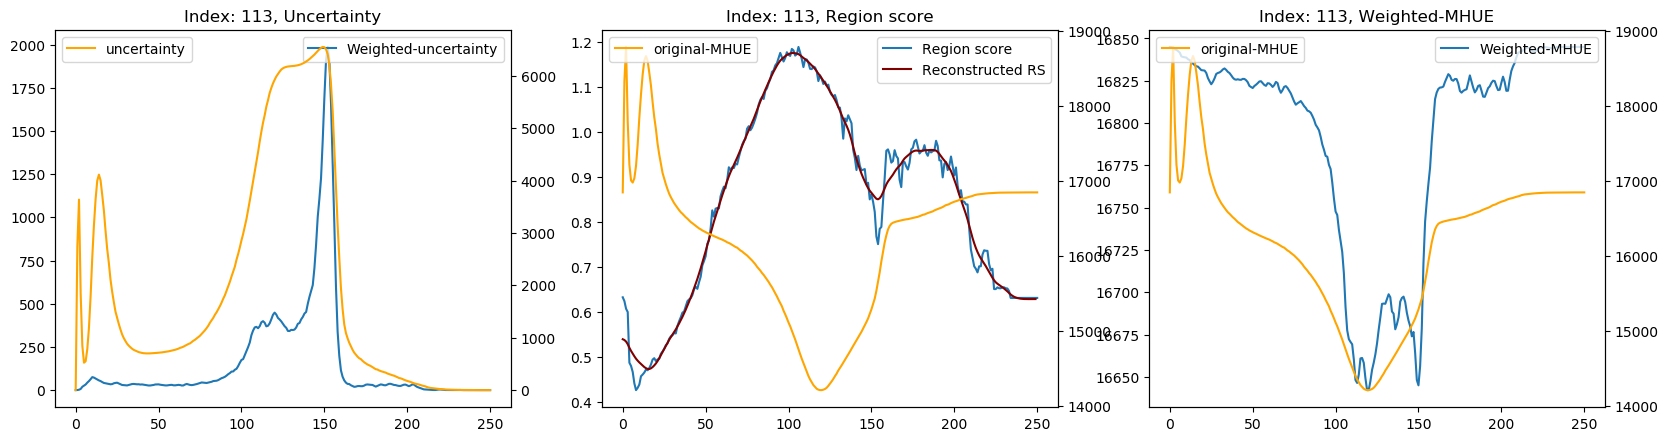

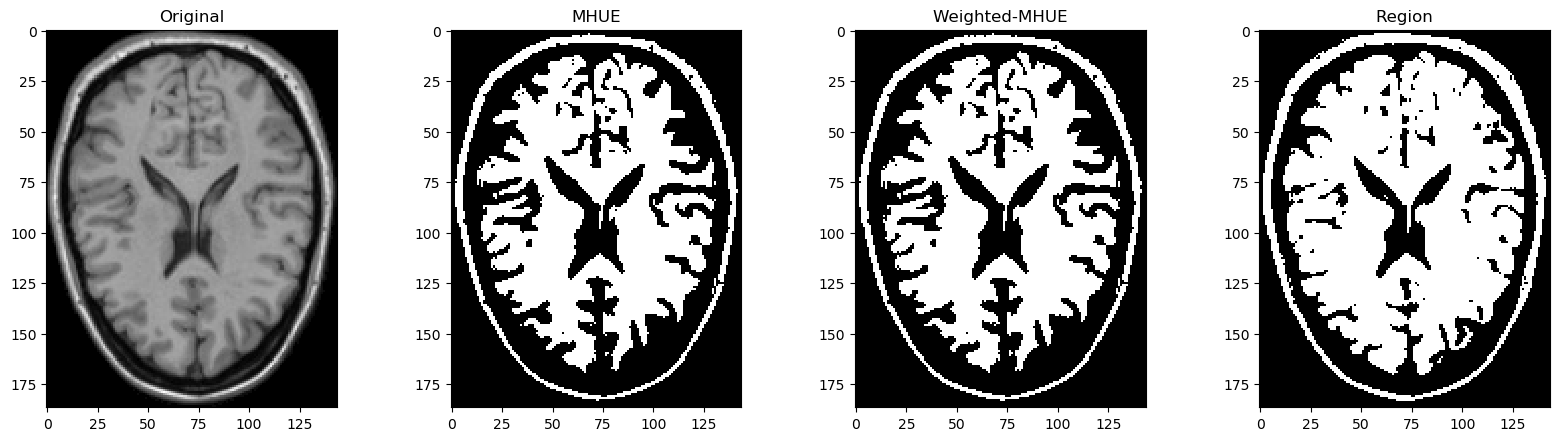

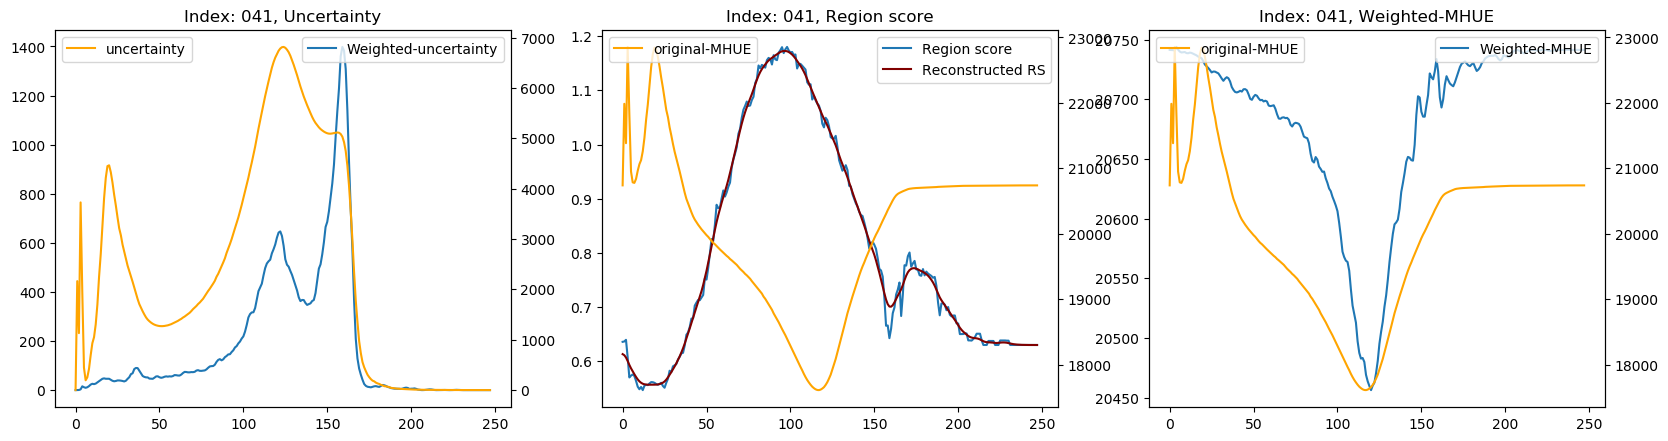

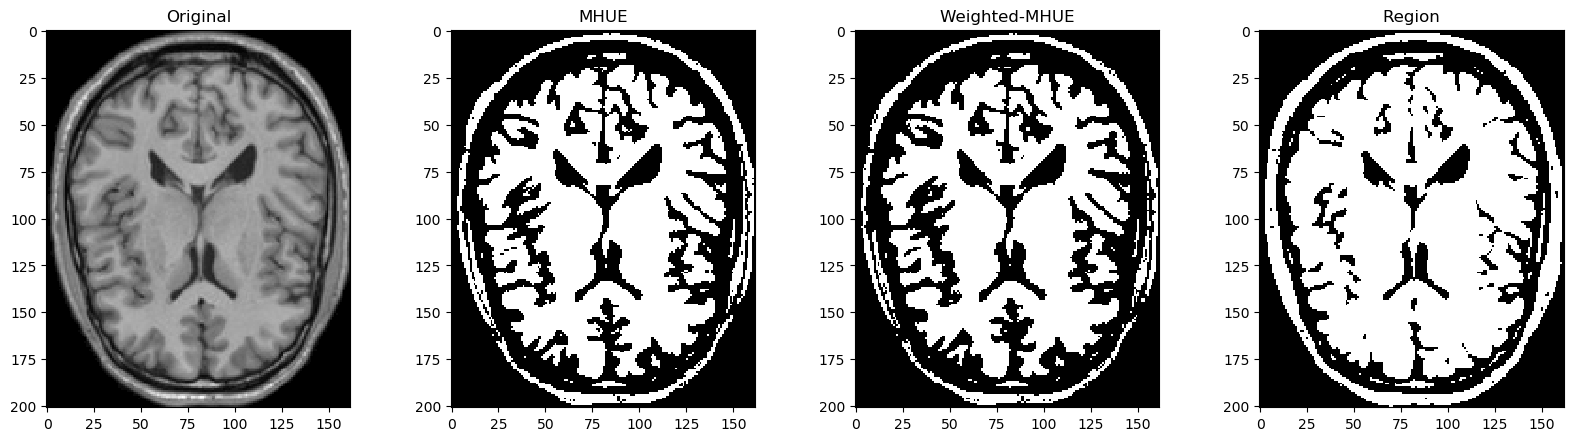

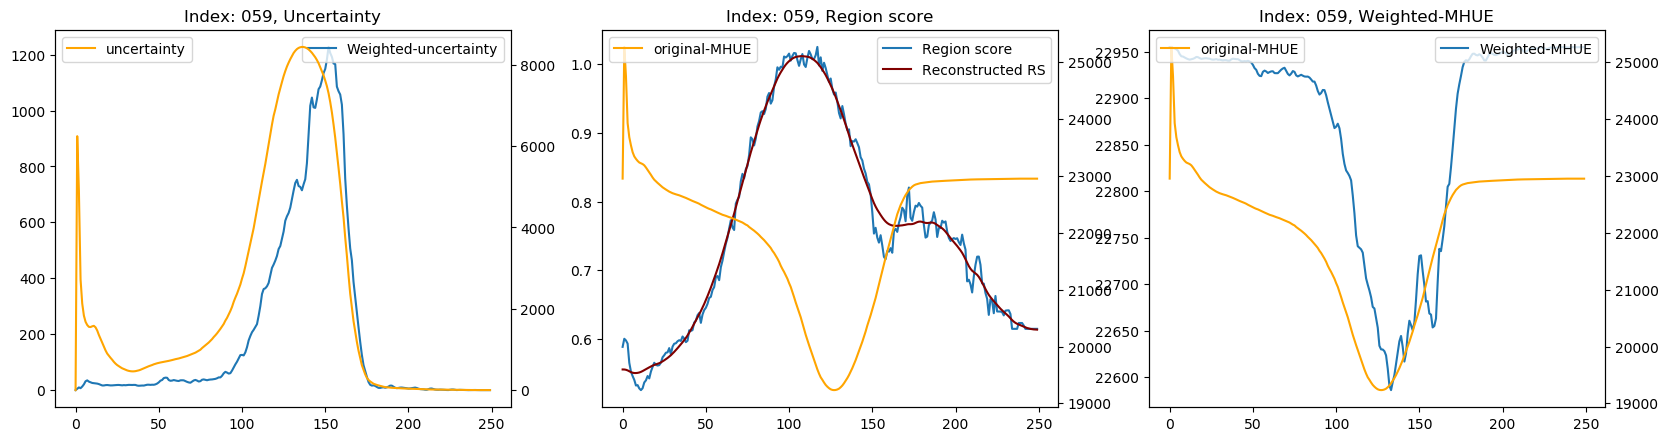

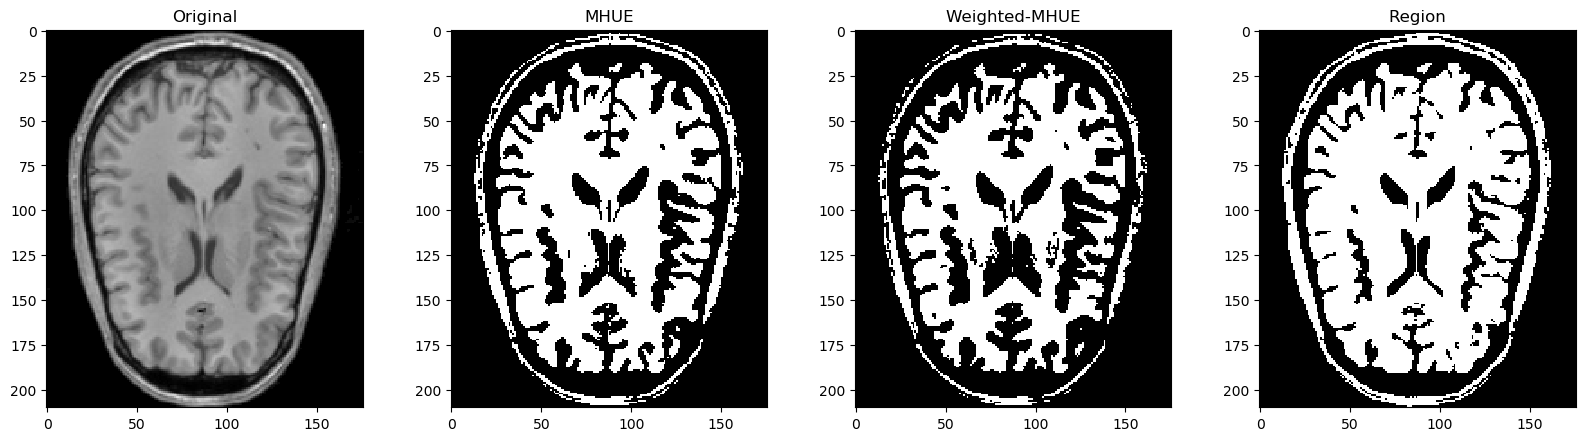

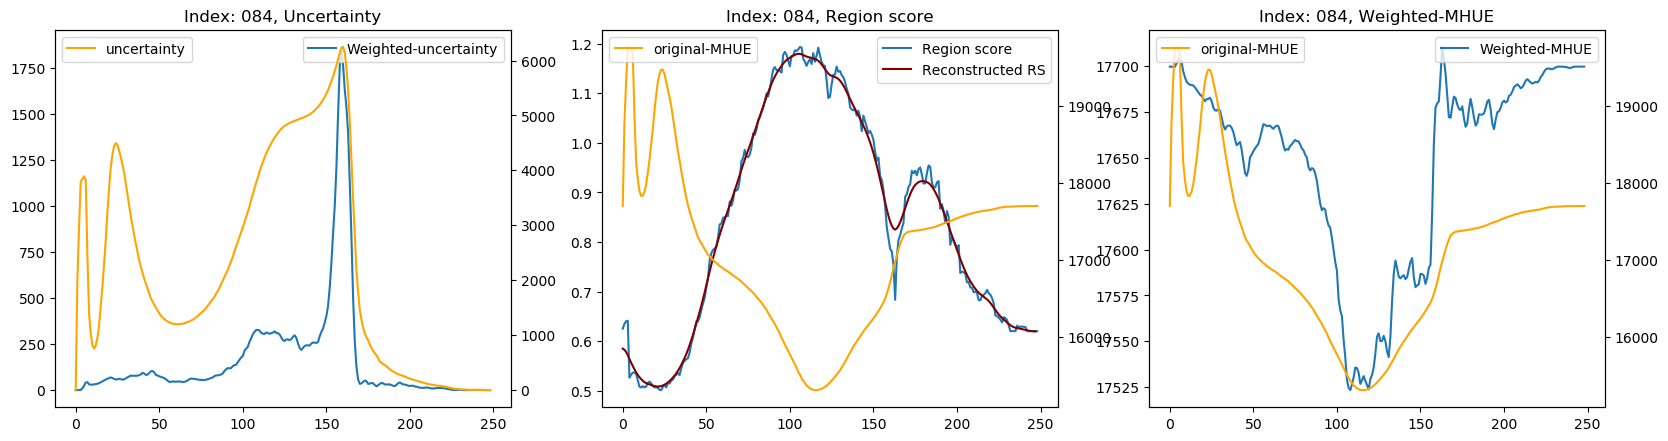

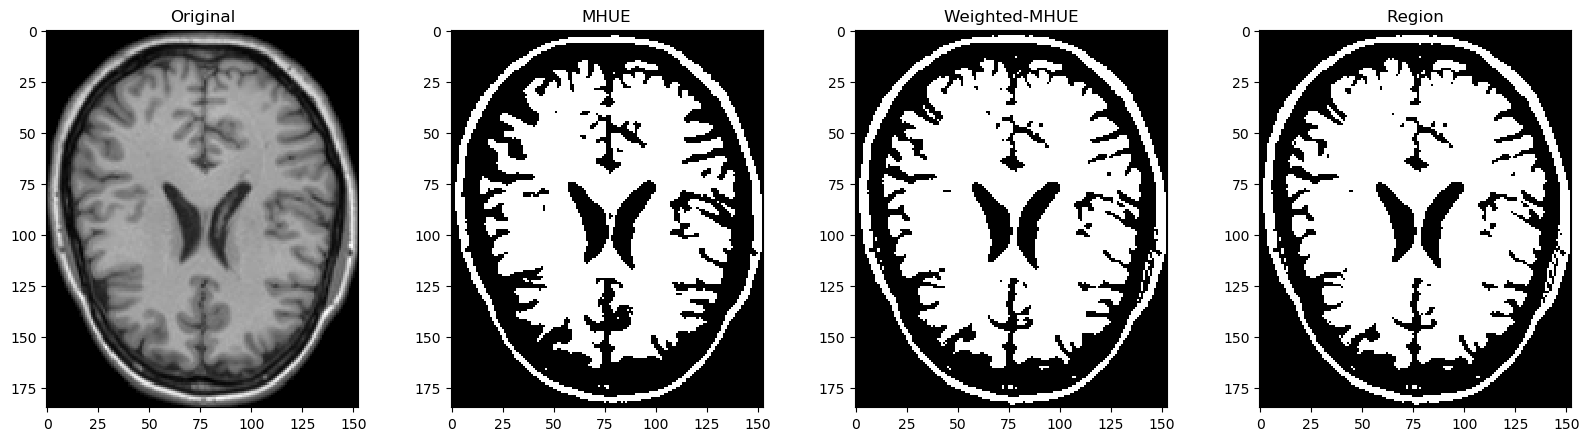

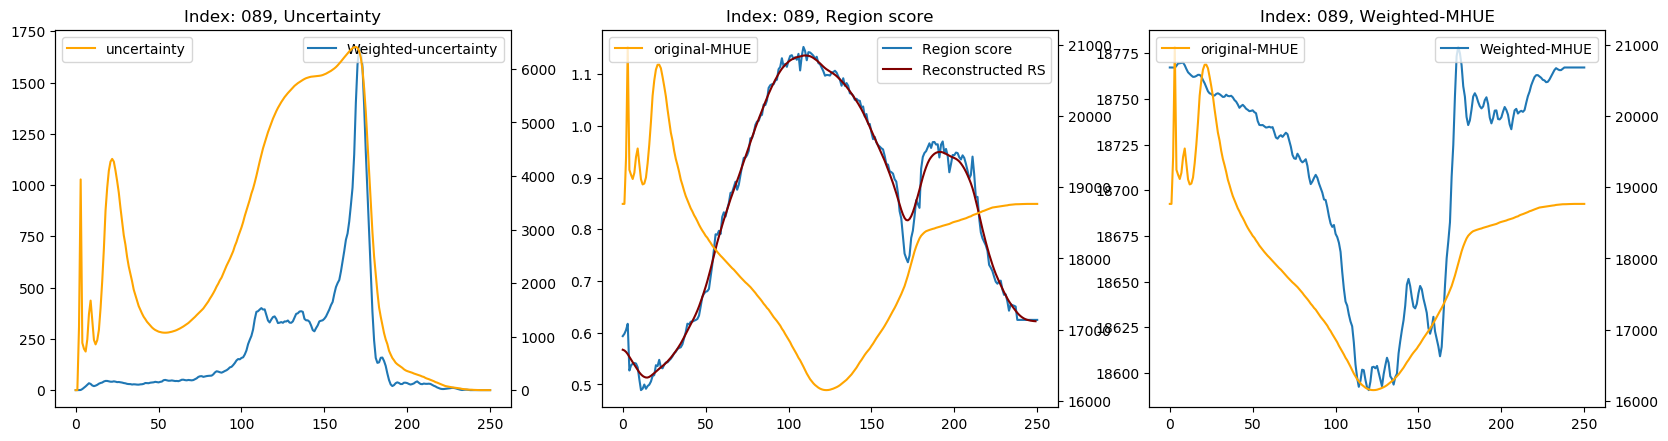

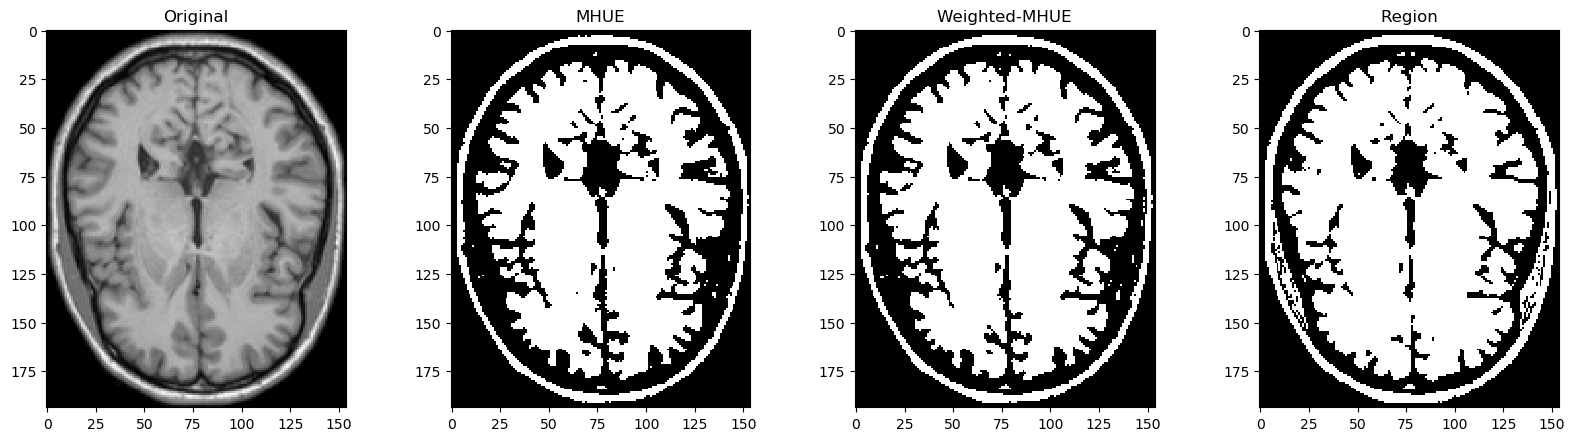

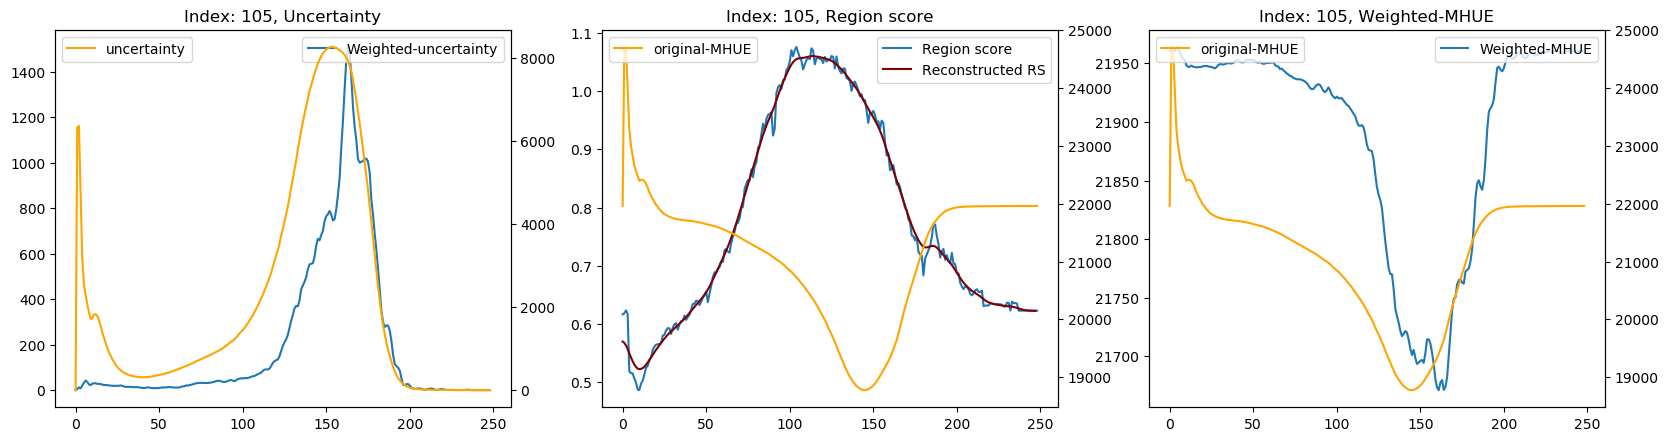

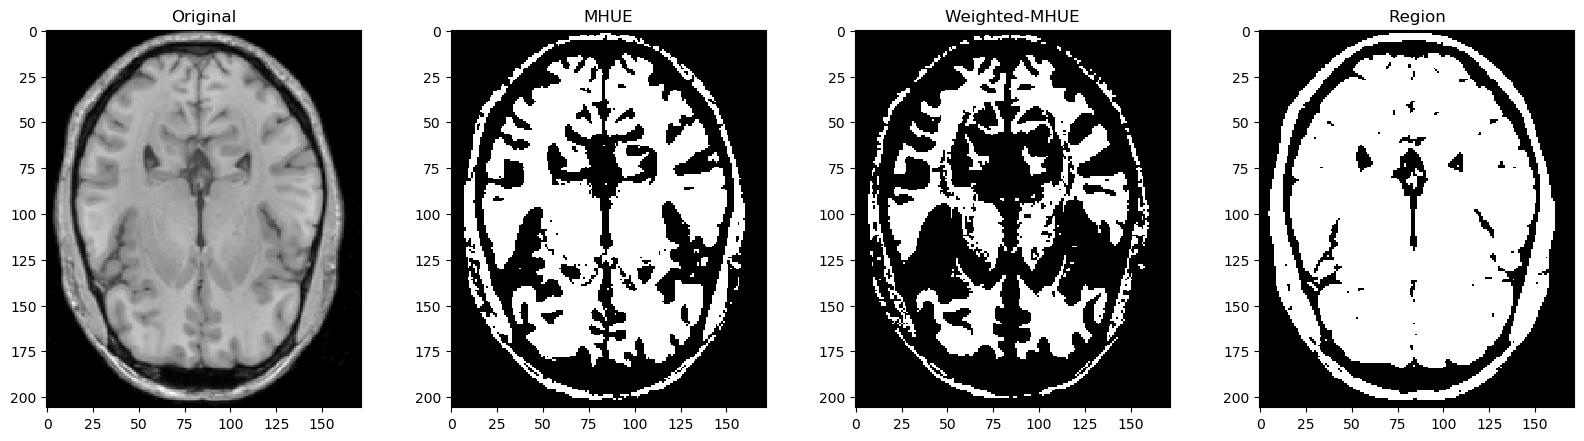

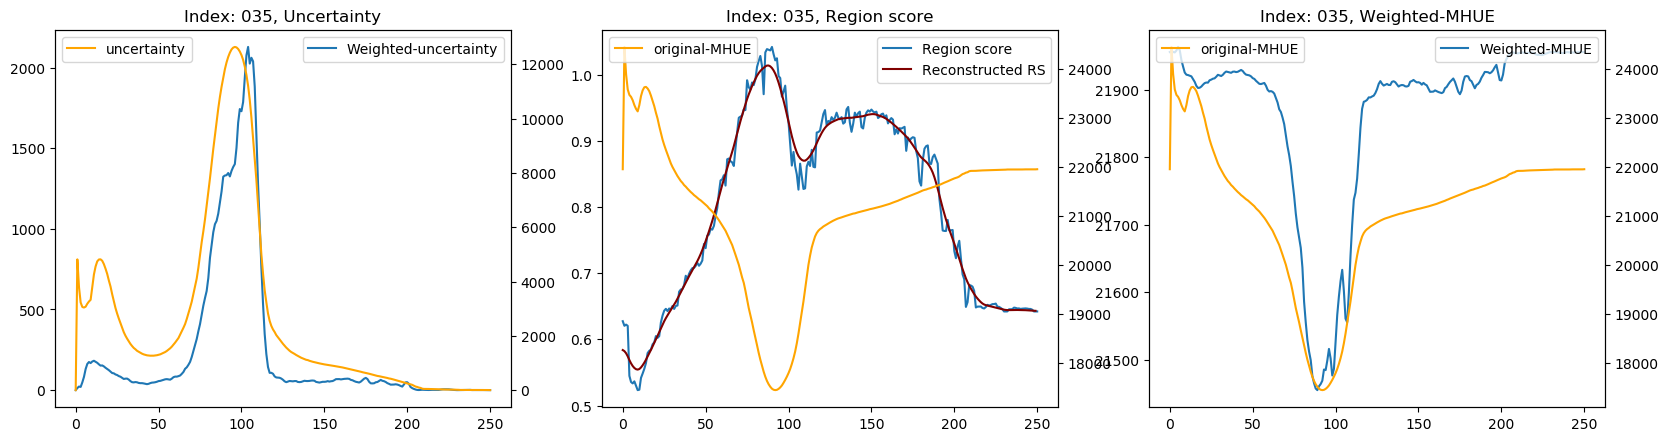

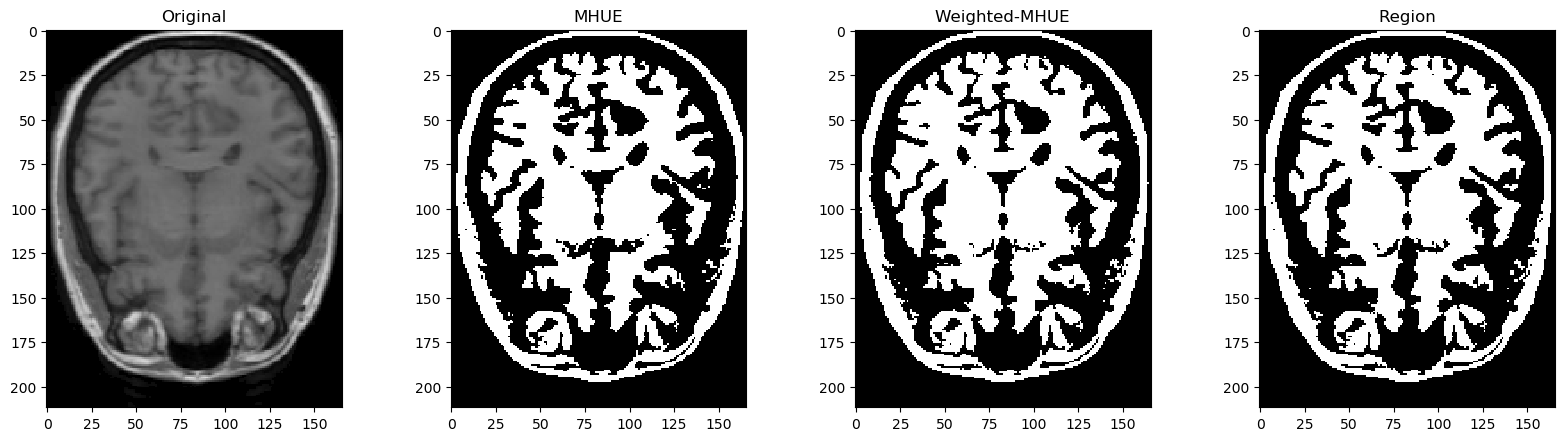

In [29]:
from vmdpy import VMD

for i in range(len(_img)):
    _u = list(map(lambda x:np.sum(x),_uncertainty[i]))
    _uw = list(map(lambda x:np.sum(x),_uncertaintyw[i]))
    _e = list(map(lambda x:np.sum(x),_mhue[i]))
    _ew = list(map(lambda x:np.sum(x),_mhuew[i]))
    _r = list(map(lambda x:np.mean(x),_region[i]))
    
    fig = plt.figure(figsize=(20,5))
    ax1 = fig.add_subplot(131)
    ax2 = ax1.twinx()
    ax1.plot(_uw,label='Weighted-uncertainty')
    ax1.legend(loc=1)
    ax2.plot(_u,color='orange',label='uncertainty')
    ax2.legend(loc=2)
    plt.title('Index: {}, Uncertainty'.format(idx_lst[i]))
    
    ax3 = fig.add_subplot(132)
    ax4 = ax3.twinx()
    ax3.plot(_r,label='Region score')
    
    _r_recon_all, _r_recon_hat, omega = VMD(_r, alpha=2000, tau=0.0, K=5, DC=0, init=1, tol=1e-7)
    _r_recon = list(_r_recon_all[0,:])
    for mode in range(1,_r_recon_all.shape[0]):
        if np.var(_r_recon_all[mode,:])/np.sum(np.var(_r_recon_all,axis=1)) > 0.01:
            _r_recon += _r_recon_all[mode,:]
    ax3.plot(_r_recon,color='maroon',label='Reconstructed RS')
    
    ax3.legend(loc=1)
    ax4.plot(_e,color='orange',label='original-MHUE')
    ax4.legend(loc=2)
    plt.title('Index: {}, Region score'.format(idx_lst[i]))
    
    ax6 = fig.add_subplot(133)
    ax7 = ax6.twinx()
    ax6.plot(_ew,label='Weighted-MHUE')
    ax6.legend(loc=1)
    ax7.plot(_e,color='orange',label='original-MHUE')
    ax7.legend(loc=2)
    plt.title('Index: {}, Weighted-MHUE'.format(idx_lst[i]))
    
    fig = plt.figure(figsize=(20,5))
    ax1 = fig.add_subplot(141)
    ax1.imshow(_img[i])
    ax1.set_title('Original')
    tlower = np.min(_img[i]) + 2
    t1 = np.argmin(_e) + tlower
    t2 = np.argmin(_ew) + tlower
    t3 = np.argmax(_r) + tlower
    ax2 = fig.add_subplot(142)
    _,res = cv.threshold(_img[i],t1,255,0)
    ax2.imshow(res)
    ax2.set_title('MHUE')
    ax3 = fig.add_subplot(143)
    _,tmp = cv.threshold(_img[i],t2,255,0)
    ax3.imshow(tmp)
    ax3.set_title('Weighted-MHUE')
    ax4 = fig.add_subplot(144)
    _,tmp = cv.threshold(_img[i],t3,255,0)
    ax4.imshow(tmp)
    ax4.set_title('Region')

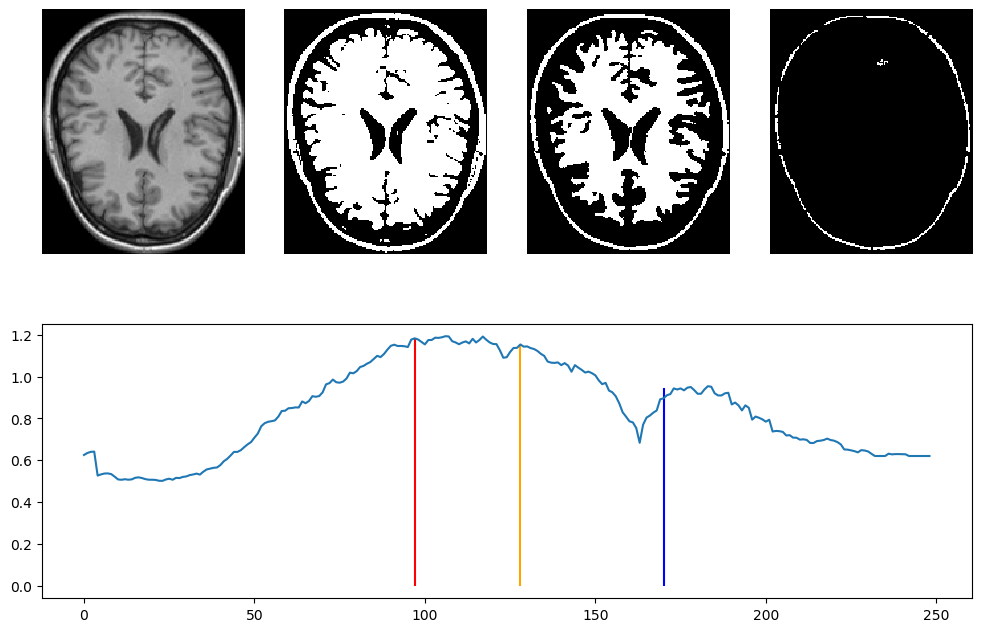

In [32]:
idx = -4

region_tmp = list(map(lambda x:np.mean(x),_region[idx]))
tlower = np.min(_img[idx])+2
plt.figure(figsize=(12,8))
plt.subplot(241)
plt.axis('off')
plt.imshow(_img[idx])
plt.subplot(242)
plt.axis('off')
_,tmp = cv.threshold(_img[idx],103+tlower,255,0)
plt.imshow(tmp)
plt.subplot(243)
plt.axis('off')
_,tmp = cv.threshold(_img[idx],128+tlower,255,0)
plt.imshow(tmp)
plt.subplot(244)
plt.axis('off')
_,tmp = cv.threshold(_img[idx],175+tlower,255,0)
plt.imshow(tmp)
plt.subplot(212)
plt.plot(region_tmp)
tlower = np.min(_img[idx])+2
plt.vlines(x=97,ymin=0,ymax=region_tmp[103],color='r')
plt.vlines(x=128,ymin=0,ymax=region_tmp[128],color='orange')
plt.vlines(x=170,ymin=0,ymax=region_tmp[175],color='blue')

97


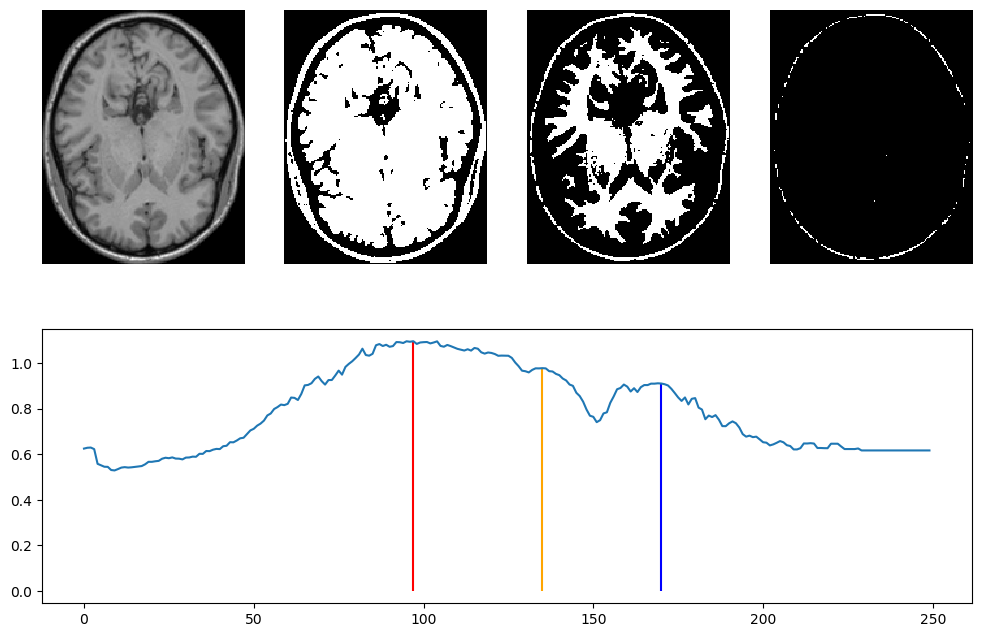

In [148]:
idx = 1

region_tmp = list(map(lambda x:np.mean(x),_region[idx]))
print(np.argmax(region_tmp))
tlower = np.min(_img[idx])+2
plt.figure(figsize=(12,8))
plt.subplot(241)
plt.axis('off')
plt.imshow(_img[idx])
plt.subplot(242)
plt.axis('off')
_,tmp = cv.threshold(_img[idx],97+tlower,255,0)
plt.imshow(tmp)
plt.subplot(243)
plt.axis('off')
_,tmp = cv.threshold(_img[idx],135+tlower,255,0)
plt.imshow(tmp)
plt.subplot(244)
plt.axis('off')
_,tmp = cv.threshold(_img[idx],170+tlower,255,0)
plt.imshow(tmp)
plt.subplot(212)
plt.plot(region_tmp)
tlower = np.min(_img[idx])+2
plt.vlines(x=97,ymin=0,ymax=region_tmp[97],color='r')
plt.vlines(x=135,ymin=0,ymax=region_tmp[135],color='orange')
plt.vlines(x=170,ymin=0,ymax=region_tmp[170],color='blue')

In [63]:
corres_stabs = []
fil = gauss_kernel(21,0.3)
for t in tqdm(range(len(_stab[idx]))):
    corres_stab = cv.filter2D(_stab[idx][t],-1,fil)
    corres_stabs.append(corres_stab)

In [101]:
import matplotlib
norm1 = matplotlib.colors.Normalize(vmin=0, vmax=7)
norm2 = matplotlib.colors.Normalize(vmin=-8, vmax=10)

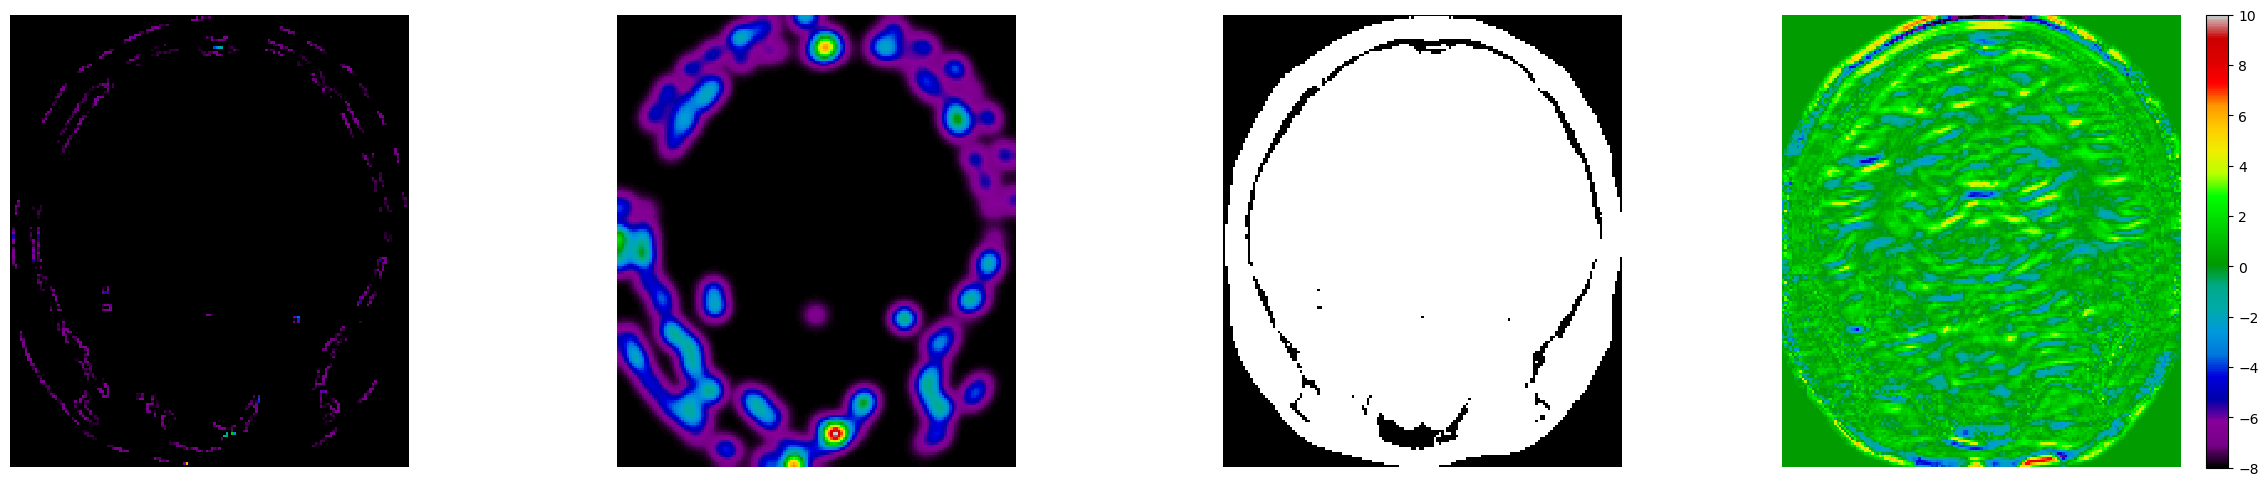

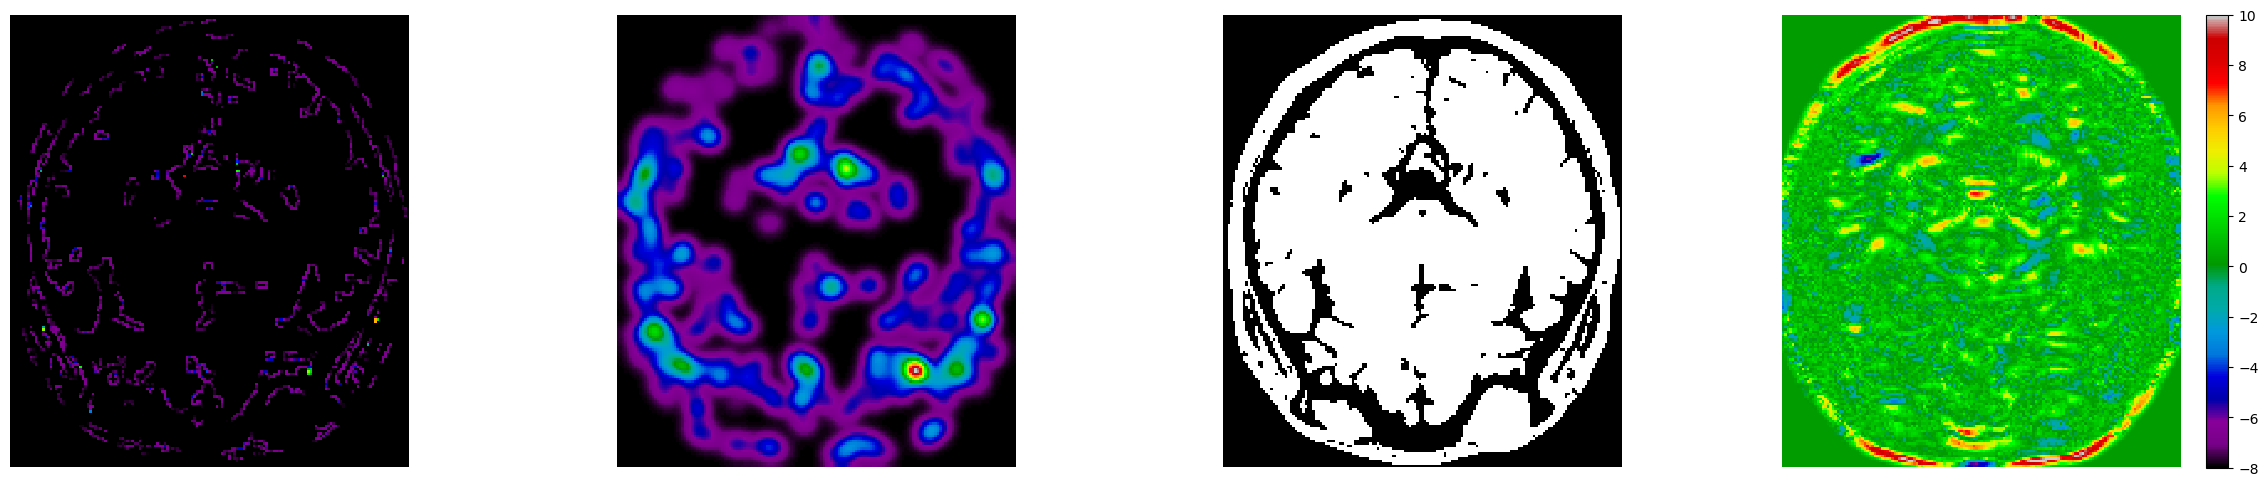

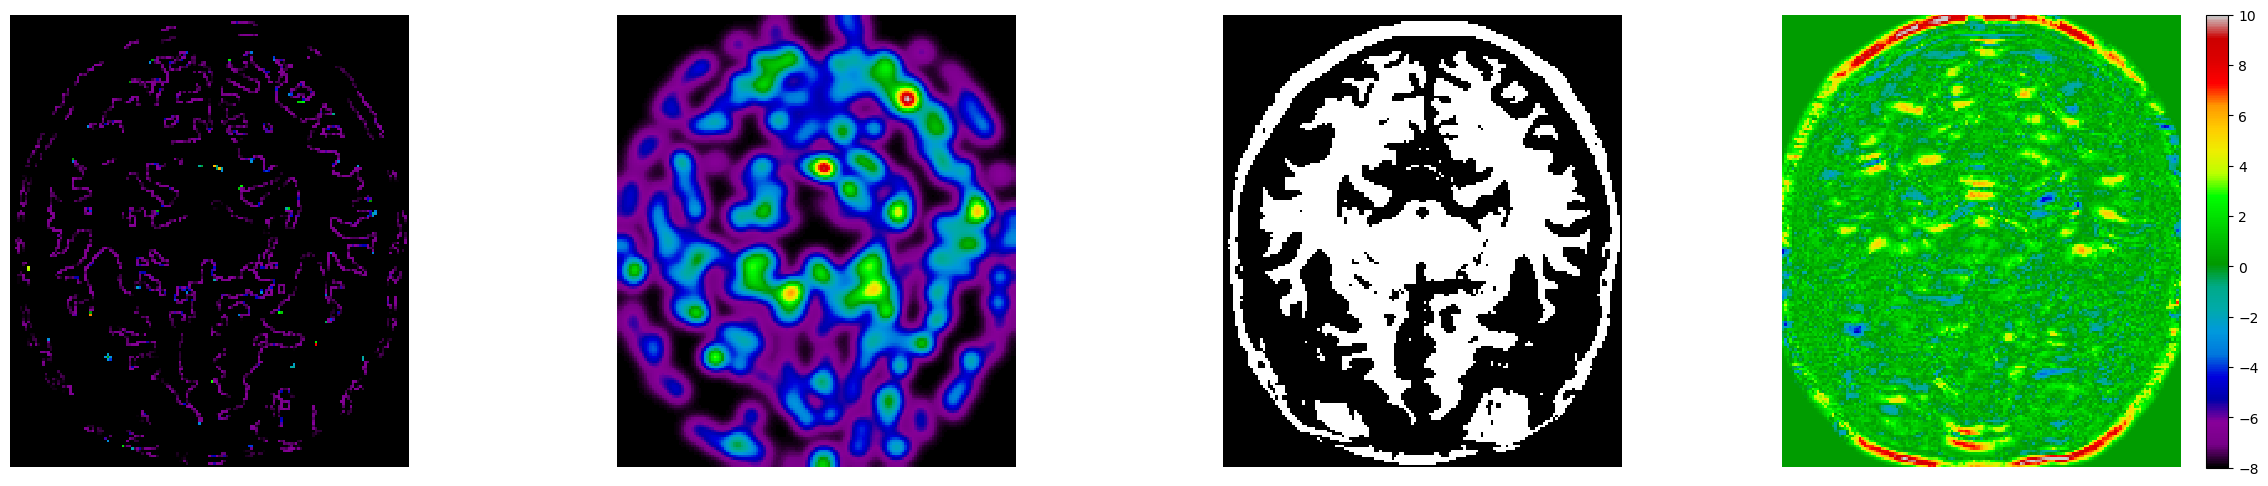

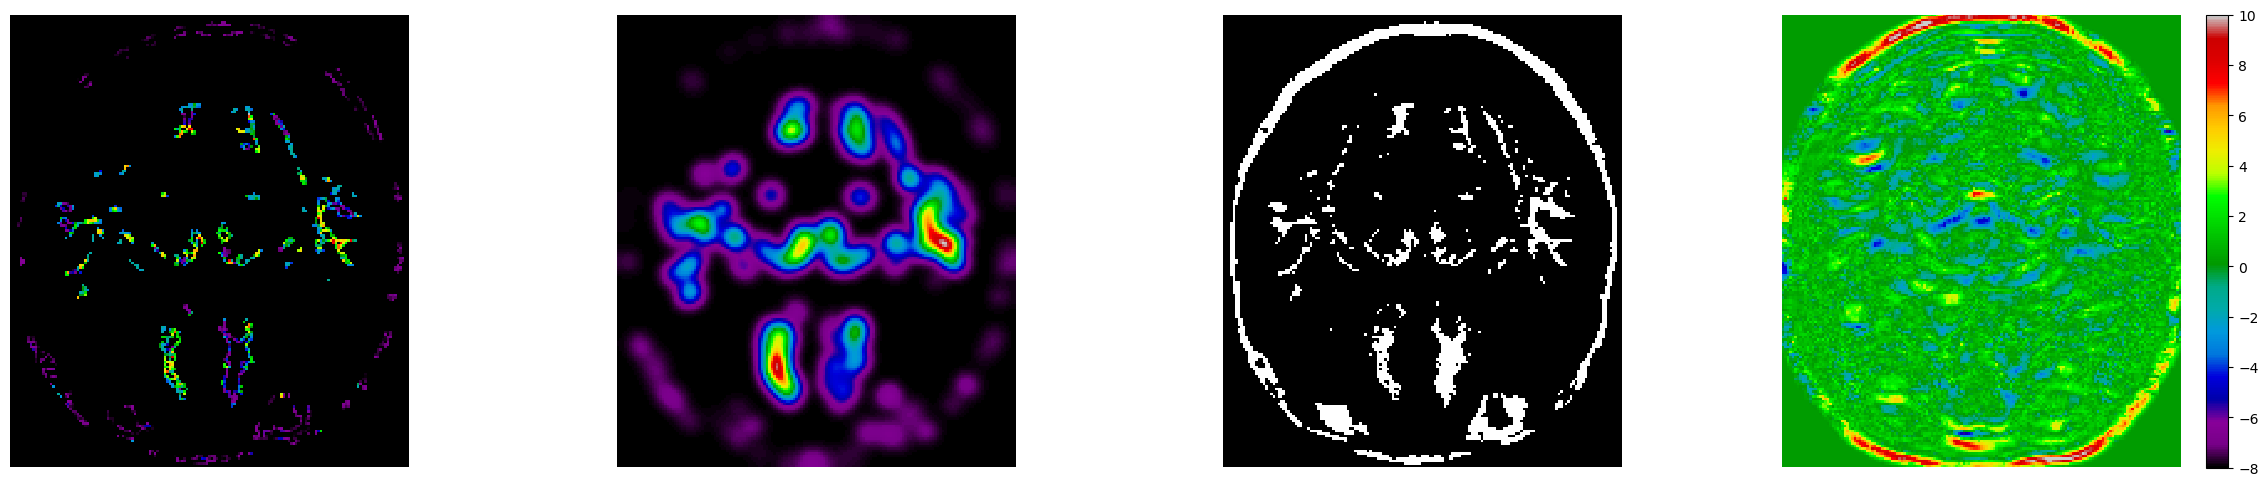

In [104]:
idx = 0

corres_stabs = []
fil = gauss_kernel(21,0.3)
for t in tqdm(range(len(_stab[idx]))):
    corres_stab = cv.filter2D(_stab[idx][t],-1,fil)
    corres_stabs.append(corres_stab)

thresh = 30
plt.figure(figsize=(30,6))
plt.subplot(141)
plt.axis('off')
plt.imshow(_stab[idx][thresh],cmap='nipy_spectral',norm=norm1)
plt.subplot(142)
plt.axis('off')
plt.imshow(corres_stabs[thresh],cmap='nipy_spectral')
plt.subplot(143)
plt.axis('off')
_,res = cv.threshold(_img[idx],thresh+np.min(_img[idx])+2,255,0)
plt.imshow(res)
plt.subplot(144)
plt.axis('off')
plt.imshow(_region[idx][thresh],cmap='nipy_spectral',norm=norm2)
plt.colorbar()

thresh = 99
plt.figure(figsize=(30,6))
plt.subplot(141)
plt.axis('off')
plt.imshow(_stab[idx][thresh],cmap='nipy_spectral',norm=norm1)
plt.subplot(142)
plt.axis('off')
plt.imshow(corres_stabs[thresh],cmap='nipy_spectral')
plt.subplot(143)
plt.axis('off')
_,res = cv.threshold(_img[idx],thresh+np.min(_img[idx])+2,255,0)
plt.imshow(res)
plt.subplot(144)
plt.axis('off')
plt.imshow(_region[idx][thresh],cmap='nipy_spectral',norm=norm2)
plt.colorbar()

thresh = 128
plt.figure(figsize=(30,6))
plt.subplot(141)
plt.axis('off')
plt.imshow(_stab[idx][thresh],cmap='nipy_spectral',norm=norm1)
plt.subplot(142)
plt.axis('off')
plt.imshow(corres_stabs[thresh],cmap='nipy_spectral')
plt.subplot(143)
plt.axis('off')
_,res = cv.threshold(_img[idx],thresh+np.min(_img[idx])+2,255,0)
plt.imshow(res)
plt.subplot(144)
plt.axis('off')
plt.imshow(_region[idx][thresh],cmap='nipy_spectral',norm=norm2)
plt.colorbar()

thresh = 160
plt.figure(figsize=(30,6))
plt.subplot(141)
plt.axis('off')
plt.imshow(_stab[idx][thresh],cmap='nipy_spectral',norm=norm1)
plt.subplot(142)
plt.axis('off')
plt.imshow(corres_stabs[thresh],cmap='nipy_spectral')
plt.subplot(143)
plt.axis('off')
_,res = cv.threshold(_img[idx],thresh+np.min(_img[idx])+2,255,0)
plt.imshow(res)
plt.subplot(144)
plt.axis('off')
plt.imshow(_region[idx][thresh],cmap='nipy_spectral',norm=norm2)
plt.colorbar()

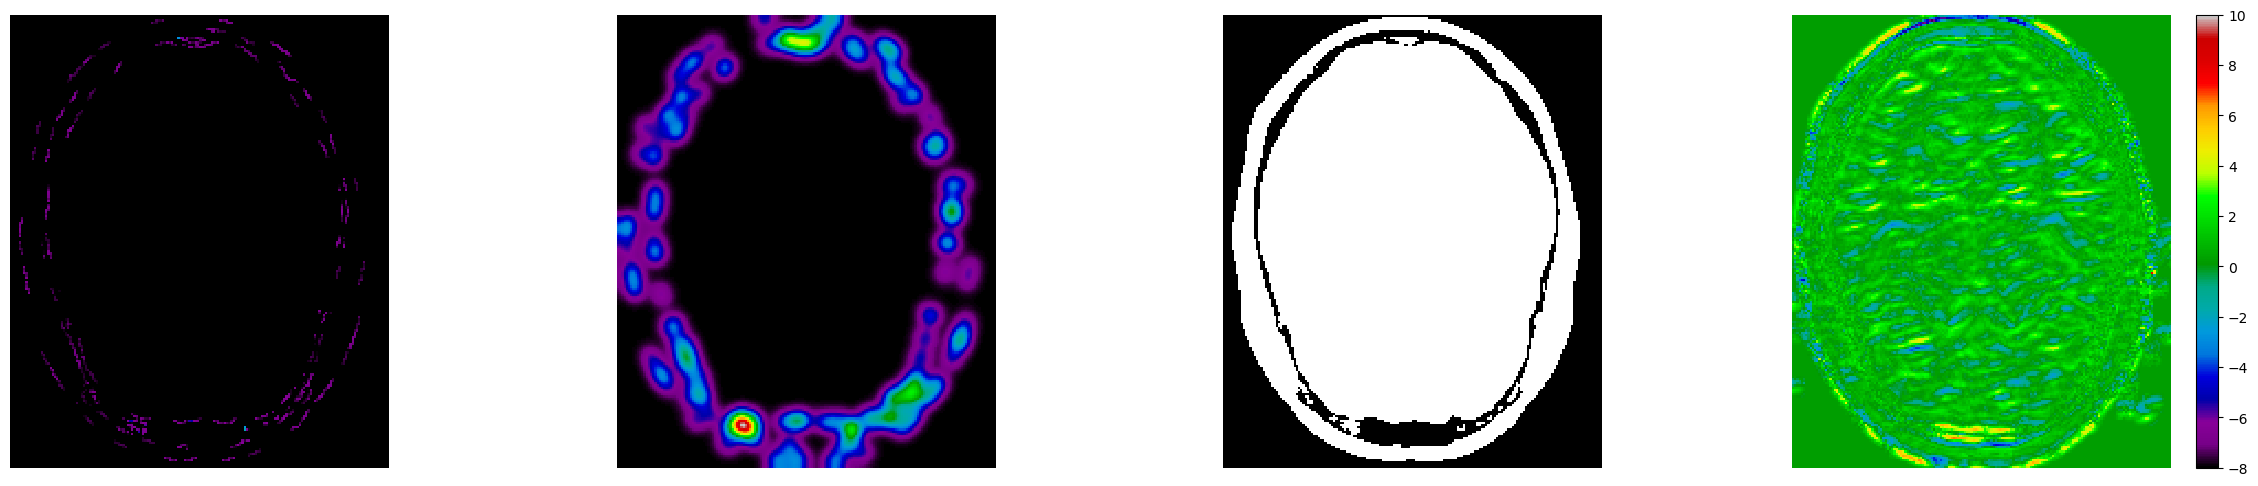

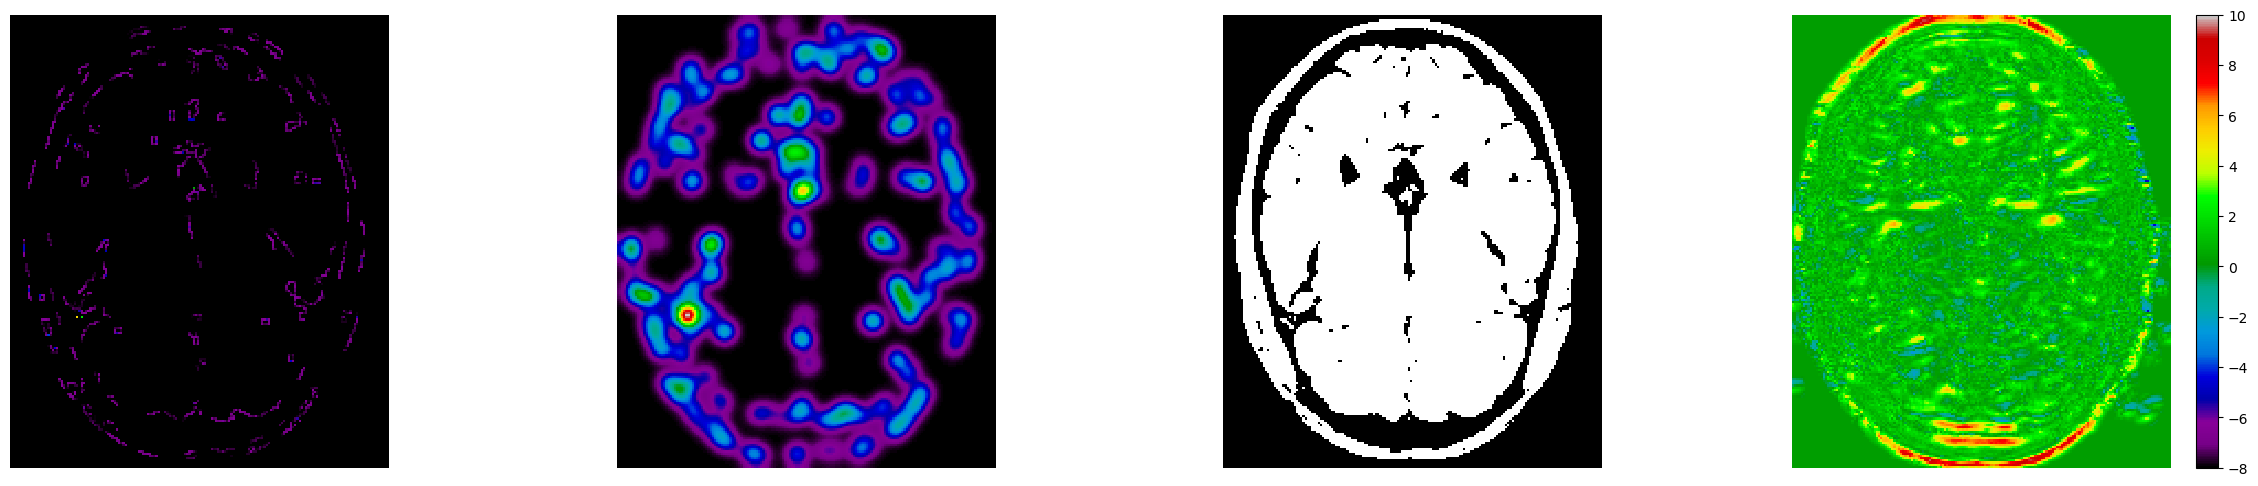

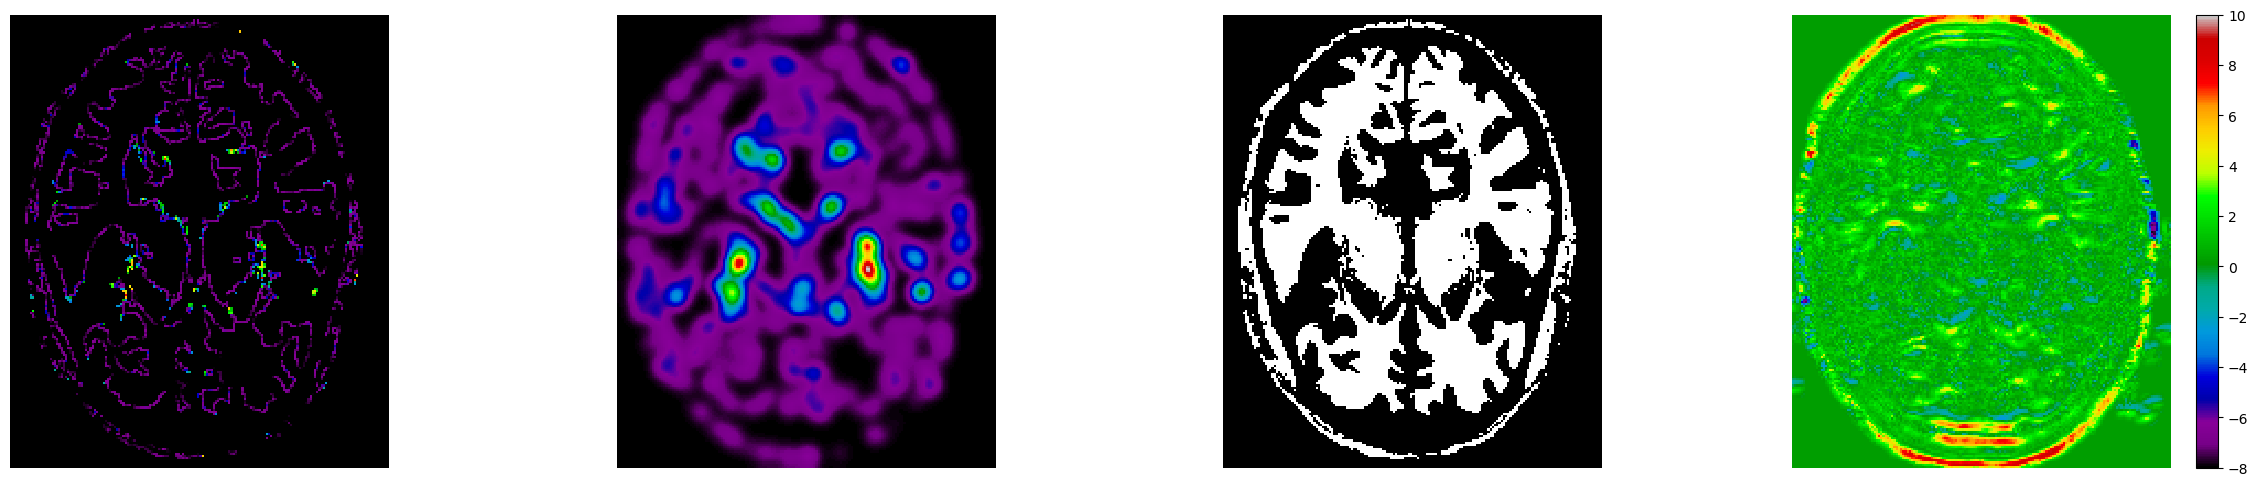

In [106]:
idx = -2

corres_stabs = []
fil = gauss_kernel(21,0.3)
for t in tqdm(range(len(_stab[idx]))):
    corres_stab = cv.filter2D(_stab[idx][t],-1,fil)
    corres_stabs.append(corres_stab)

thresh = 40
plt.figure(figsize=(30,6))
plt.subplot(141)
plt.axis('off')
plt.imshow(_stab[idx][thresh],cmap='nipy_spectral',norm=norm1)
plt.subplot(142)
plt.axis('off')
plt.imshow(corres_stabs[thresh],cmap='nipy_spectral')
plt.subplot(143)
plt.axis('off')
_,res = cv.threshold(_img[idx],thresh+np.min(_img[idx])+2,255,0)
plt.imshow(res)
plt.subplot(144)
plt.axis('off')
plt.imshow(_region[idx][thresh],cmap='nipy_spectral',norm=norm2)
plt.colorbar()
# cbar.set

thresh = 106
plt.figure(figsize=(30,6))
plt.subplot(141)
plt.axis('off')
plt.imshow(_stab[idx][thresh],cmap='nipy_spectral',norm=norm1)
plt.subplot(142)
plt.axis('off')
plt.imshow(corres_stabs[thresh],cmap='nipy_spectral')
plt.subplot(143)
plt.axis('off')
_,res = cv.threshold(_img[idx],thresh+np.min(_img[idx])+2,255,0)
plt.imshow(res)
plt.subplot(144)
plt.axis('off')
plt.imshow(_region[idx][thresh],cmap='nipy_spectral',norm=norm2)
plt.colorbar()

thresh = 153
plt.figure(figsize=(30,6))
plt.subplot(141)
plt.axis('off')
plt.imshow(_stab[idx][thresh],cmap='nipy_spectral',norm=norm1)
plt.subplot(142)
plt.axis('off')
plt.imshow(corres_stabs[thresh],cmap='nipy_spectral')
plt.subplot(143)
plt.axis('off')
_,res = cv.threshold(_img[idx],thresh+np.min(_img[idx])+2,255,0)
plt.imshow(res)
plt.subplot(144)
plt.axis('off')
plt.imshow(_region[idx][thresh],cmap='nipy_spectral',norm=norm2)
plt.colorbar()

In [59]:
def gauss_kernel(kernel_size, sigma):
    kernel = np.zeros((kernel_size, kernel_size))
    center = kernel_size//2
    if sigma<=0:
        sigma = ((kernel_size-1)*0.5-1)*0.3+0.8
    s = sigma**2
    sum_val =  0
    for i in range(kernel_size):
        for j in range(kernel_size):
            x, y = i-center, j-center
            kernel[i, j] = np.exp(-(x**2+y**2)/2*s)
            sum_val += kernel[i, j]
    kernel = kernel/sum_val
    return kernel